In [1]:
from common import *

import xml.etree.ElementTree as ET
from pymongo import MongoClient
import pymongo
from matplotlib import pyplot as plt

from pymystem3 import Mystem
from bson.objectid import ObjectId
import re
from bson.son import SON
import gridfs
from pprint import pprint
import tflearn

import networkx as nx
import pickle
import collections

from matplotlib import pyplot as plt

2017-10-18 11:32:03,294 [MainThread  ] [INFO ]  Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2017-10-18 11:32:03,326 [MainThread  ] [INFO ]  Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


# Parse xml

In [6]:
fname = join(DATA_FOLDER, 'rawdata', 'all_docs_raw.txt')

In [3]:
# all_docs = !find {join(DATA_FOLDER, 'rawdata')} -name '*.xml'
# # all_docs = glob(join(DATA_FOLDER, 'rawdata') + '/**/*.xml', recursive=True)

# all_docs = sorted(all_docs)
# with open(fname, mode='wt') as f:
#     f.write('\n'.join(all_docs))

In [7]:
with open(fname, mode='r') as f:
    all_docs = f.read().splitlines()

In [8]:
len(all_docs)

1267185

In [6]:
def get_node(root, name, lang='ru'):
    for node in root.iter(name):
        if 'lang' in node.attrib:
            if node.attrib['lang'].lower() == lang:
                return node
        else:
            return node

In [7]:
def get_root(fname):
    with open(fname, 'r') as f: #encoding='utf8'
        text = f.read()
        text = text.replace('&deg', 'deg')
    
    try:
        root = ET.fromstring(text)
    except:
        print(fname, 'parse error')
        return
    return root

def parse_xml(fname, mstem, lemmatize=True, save_raw=True, only_mpk=False):
    doc = {}

    root = get_root(fname)
    if root is None:
        return
    
    doc.update(root.attrib)        
    
    raw_texts = {}
    
    SDOBI = get_node(root, 'SDOBI')
    if SDOBI is not None:
        for name, addres in zip(['doc-number', 'kind', 'date-publ', 'country'],
                                ['./B100/B110', './B100/B130', './B100/B140/date', './B100/B190']):
            if name not in doc:
                node = SDOBI.find(addres)
                if node is not None:
                    doc[name] = node.text
        
        mpk_nodes = SDOBI.findall('./B500/B510EP/classification-ipcr')
        mpk_list = []
        for mpk in mpk_nodes:
            doc_mpk = {}
            for name, addres in zip(['section', 'class', 'subclass', 'main-group', 'subgroup'], 
                                    ['./section', './class', './subclass', './main-group', './subgroup']):
                node = mpk.find(addres)
                if node is not None and node.text is not None:
                    doc_mpk[name] = node.text.strip()
            if len(doc_mpk):
                mpk_list.append(doc_mpk)
        if len(mpk_list): doc['mpk'] = mpk_list
        
        if only_mpk: return doc
                    
        node1 = SDOBI.find('./B500/ru-b540/ru-b542')
        node2 = SDOBI.find('./B500/B540/B542')
        node = max(node1, node2)
        if node is not None:
            raw_texts['name'] = node.text.lower()
        else:
            print(fname, 'no name')
            
        node = SDOBI.find('./B500/B560/ru-b560')
        if node is not None:
            doc['ru-b560'] = ' '.join(node.itertext())            
    else:
        print('no SDOBI: ' + fn)
    
    if only_mpk: return doc

    node = get_node(root, 'abstract')
    if node is not None:
        raw_texts['abstract'] = ' '.join(node.itertext()).lower()

    node = get_node(root, 'description')
    if node is not None:
        raw_texts['description'] = ' '.join(node.itertext()).lower()

    node = get_node(root, 'claims')
    if node is not None:
        raw_texts['claims'] = ' '.join(node.itertext()).lower()            
    
    for k,v in raw_texts.items():
        if save_raw:
            doc[k + '_raw'] = v
        if lemmatize:
            doc[k] = ''.join(mstem.lemmatize(v))    
    
    return doc

# Test

In [10]:
afile = '../data/rawdata/2016/RU/A/20161227/2015116494/2015116494.xml'
c1file = '../data/rawdata/2016/RU/C1/20161227/0002605713/0002605713.xml'
c2file = '../data/rawdata/2016/RU/C2/20160127/0002573901/0002573901.xml'
ufile = '../data/rawdata/2016/RU/U1/20161210/0000166582/0000166582.xml'

In [16]:
mstem = Mystem()
doc = parse_xml(ufile, mstem, only_mpk=True)

In [20]:
print(doc['mpk'], doc['doc-number'])

([{'section': 'F', 'main-group': '15', 'class': '16', 'subclass': 'J', 'subgroup': '18'}], '0000166582')


In [21]:
for k,v in doc.items():
    print('%s: %s' % (k,v))

lang: ru
status: N
kind: U1
country: RU
dtd-version: ru-patent-document-v1-4
mpk: [{'section': 'F', 'main-group': '15', 'class': '16', 'subclass': 'J', 'subgroup': '18'}]
date-publ: 20161210
bullid: d34
doc-number: 0000166582


# Fill database with data

In [5]:
client = MongoClient('fips')
db = client.fips

In [9]:
# result = db.patents.create_index([('doc-number', pymongo.ASCENDING),
#                                    ('kind', pymongo.ASCENDING),
#                                    ('country', pymongo.ASCENDING),
#                                    ('date-publ', pymongo.ASCENDING)], unique=True)
# sorted(list(db.patents.index_information()))

In [13]:
def save_to_mongodb(doc_list, lemmatize=True, save_raw=True, 
                    only_mpk=False, replace=False):
    client = MongoClient('fips')
    db = client.fips
    patents = db.patents

    mstem = Mystem()

    replaced = []
    for fn in doc_list:
        doc = parse_xml(fn, mstem, lemmatize=lemmatize, 
                        save_raw=save_raw, only_mpk=only_mpk)
#         print(fn)
        if doc is not None:
            func = patents.replace_one if replace else patents.update_one
            if not replace:
                _doc = {'$set': doc}
            else:
                _doc = doc
            rep = func(
                {
                    'doc-number': doc['doc-number'],
                    'kind': doc['kind'],
                    'country': doc['country'],
                    'date-publ': doc['date-publ']
                },
                _doc,
                upsert=True)
        replaced.append(rep)
    return replaced

In [11]:
len(all_docs)//(cpu_count*100)

3167

In [12]:
split_on = len(all_docs)//(cpu_count*100)

for i,sub_docs in enumerate(tqdm(np.array_split(all_docs, split_on))):
    ! rm -f ../data/out
    ! echo {i} >> ../data/out
    
    parallelizer = Parallel(n_jobs=cpu_count)

    # this iterator returns the functions to execute for each task
    tasks_iterator = ( delayed(save_to_mongodb)(list_block, False, False, True) for 
                      list_block in grouper(100, sub_docs) ) 
    result = parallelizer( tasks_iterator )

 21%|██▏       | 680/3167 [13:48<1:41:01,  2.44s/it]

('../data/rawdata/1999/RU/C1/19990220/0002126409/0002126409.xml', 'parse error')


 55%|█████▍    | 1728/3167 [42:55<50:56,  2.12s/it]  

('../data/rawdata/2008/RU/C1/20080810/0002330869/0002330869.xml', 'parse error')


 59%|█████▉    | 1866/3167 [47:34<57:55,  2.67s/it]  

('../data/rawdata/2009/RU/C1/20090227/0002347582/0002347582.xml', 'parse error')


100%|██████████| 3167/3167 [1:31:39<00:00,  1.32s/it]


[file](../data/rawdata/1995/RU/C1/19951227/0002051175/0002051175.xml)

In [74]:
all_docs = glob(join(DATA_FOLDER, 'PatDocs14_7_2017/**/*.xml'), replace=True)

replaced = save_to_mongodb(all_docs)

../data/PatDocs14_7_2017/2012129077_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2009143216_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2009149309_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2007134266_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2010119186_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2009146819_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2011112878_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2010105892_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2010133566_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2011105152_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2010137098_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2010152978_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2010143535_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2009148052_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/201011031

../data/PatDocs14_7_2017/2010105546_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2010149626_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2011112909_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2010115879_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2010112298_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2007138841_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2010146730_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2012132571_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2009110186_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2010122997_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2011121256_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2013108475_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2009104071_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/2010120940_A_10010101_RU/PatentDocument.xml
../data/PatDocs14_7_2017/201012885

../data/PatDocs14_7_2017/2009139288_A_10010101_RU/PatentDocument.xml


In [91]:
replaced[0].raw_result

{u'n': 1, u'nModified': 1, u'ok': 1.0, 'updatedExisting': True}

In [16]:
# docs = []
# mstem = Mystem()

# for fn in tqdm(all_docs):
#     doc = parse_xml(fn, mstem, False, False)
#     if doc is not None:
#         patents.insert_one(doc)
# #         docs.append(doc)

In [ ]:
# patents.insert_many(docs)

# Analyze data

In [105]:
client = MongoClient('fips')
db = client.fips

In [7]:
pipeline = [
     {"$group": {"_id": "$kind", "count": {"$sum": 1}}},
     {"$sort": SON([("count", -1), ("_id", -1)])}
 ]

pprint.pprint(list(db.patents.aggregate(pipeline)))

[{'_id': 'A ', 'count': 438164},
 {'_id': 'C1', 'count': 380857},
 {'_id': 'C2', 'count': 214003},
 {'_id': 'U1', 'count': 167301},
 {'_id': 'A1', 'count': 60184},
 {'_id': 'C ', 'count': 2527},
 {'_id': 'C9', 'count': 1372},
 {'_id': 'A2', 'count': 1028},
 {'_id': 'A3', 'count': 824},
 {'_id': 'U8', 'count': 650},
 {'_id': 'C8', 'count': 13},
 {'_id': 'A4', 'count': 13},
 {'_id': 'A8', 'count': 4}]


In [9]:
db.patents.find({ 'ru-b560': {'$exists': True}}).count()

591782

In [13]:
pipeline = [
    {"$match":{"ru-b560":{'$exists': True}}},
    {"$group": {"_id": "$kind", "count": {"$sum": 1}}},
    {"$sort": SON([("count", -1), ("_id", -1)])}
 ]

pprint.pprint(list(db.patents.aggregate(pipeline)))

[{'_id': 'C1', 'count': 363083},
 {'_id': 'C2', 'count': 213916},
 {'_id': 'A1', 'count': 10647},
 {'_id': 'C ', 'count': 2042},
 {'_id': 'C9', 'count': 1365},
 {'_id': 'A3', 'count': 398},
 {'_id': 'A2', 'count': 305},
 {'_id': 'C8', 'count': 12},
 {'_id': 'A4', 'count': 9},
 {'_id': 'U8', 'count': 4},
 {'_id': 'U1', 'count': 1}]


In [54]:
topn = db.patents.find({'kind': 'C1', 'ru-b560': {'$exists': True}}, 
                       {'ru-b560': 1, "_id": 0}).skip(24300).limit(100)
pprint(list(topn))

[{'ru-b560': 'Патент GB N 2024829, C 07G 7/00, \n\n1980.'},
 {'ru-b560': 'Авторское свидетельство СССР N 1404050, A 23 K 1/00, 1988 г.'},
 {'ru-b560': 'Авторское свидетельство СССР N 1284240, кл. C 21C 7/10,\n'
             '\n'
             ' 1985.'},
 {'ru-b560': 'Авторское свидетельство СССР N 1809185, кл. F 15B 15/22, '
             '1990.Авторское свидетельство СССР N 697763, кл. F 16F 9/48, '
             '1979.'},
 {'ru-b560': 'Преображенский В.И. Полупроводниковые выпрямители. М.: '
             'Энергоатомиздат, 1986, с.41-42.Авторское свидетельство СССР \n'
             '\n'
             'N 1684894, кл. H 02P 1/28, 1989.'},
 {'ru-b560': '1. Авторское свидетельство СССР N 415130, кл. B 23P 19/02, '
             '1974.2. Авторское свидетельство СССР N 1234152, кл. B 23P '
             '19/02,\n'
             ' 1986.'},
 {'ru-b560': 'Патент США N 4795248, кл. G 02C 7/04, 1989.'},
 {'ru-b560': 'ГОСТ 4347-77, с.2.'},
 {'ru-b560': 'Авторское свидетельство СССР N 286159, кл. C 03B 3

In [157]:
p = re.compile('(?i:ru|su)(?:\s*\d+\s*){5,}(?:A(?:1|2|3|4|8|)|C(?:1|2|8|9|)|U(?:1|8))*')

topn = db.patents.find({'ru-b560': {'$exists': True}}, 
                       {'ru-b560': 1})

regexed = {}
for doc in topn:
    found = p.findall(doc['ru-b560'])
    if len(found):
        regexed[str(doc['_id'])] = found
#         if doc['kind'] == 'C1':
#             print(doc['ru-b560'])

In [158]:
len(regexed)
# {'A1': 9, 'C1': 248427, 'C2': 194130, 'C8': 12, 'C9': 1211, 'U8': 4}

443793

In [159]:
sum([len(s) for s in regexed])

10651032

In [92]:
diff = list(set(regexed2.keys()).symmetric_difference(regexed.keys()))

In [93]:
len(diff)

110973

In [321]:
# for el in diff:
#     print(regexed2[el])

In [28]:
top10 = db.patents.find({'doc-number': {'$regex': '^[0]{0,}9951010$' }}).skip(0).limit(10)
pprint(list(top10))
print(top10.count())

[]
0


# In memory search

In [6]:
topn = db.patents.find({}, {'doc-number': 1, 'country': 1, 'kind': 1})

docs = {}
for doc in topn:
    _id = str(doc['_id'])
    del doc['_id']
    doc['country'] = doc['country'].upper()
    doc['kind'] = doc['kind'].upper()
    doc['doc-number'] = doc['doc-number'].zfill(10)
    docs[_id] = doc

In [7]:
len(docs)

1267184

In [8]:
pprint(list(islice(docs.items(), 100)))

[('5984c867b6b1136d71638532',
  {u'country': u'RU', u'doc-number': u'0002339883', u'kind': u'C2'}),
 ('5984dc55b6b11329e1638512',
  {u'country': u'RU', u'doc-number': u'2014151595', u'kind': u'A '}),
 ('5984b701b6b1131ad8638508',
  {u'country': u'RU', u'doc-number': u'0002050462', u'kind': u'C1'}),
 ('5984be47b6b1137bc063851d',
  {u'country': u'RU', u'doc-number': u'2000131622', u'kind': u'A '}),
 ('5984be47b6b1137bc063851e',
  {u'country': u'RU', u'doc-number': u'2000131670', u'kind': u'A '}),
 ('5984be47b6b1137bc063851f',
  {u'country': u'RU', u'doc-number': u'2000131759', u'kind': u'A '}),
 ('5984bafab6b1135495638521',
  {u'country': u'RU', u'doc-number': u'0097111856', u'kind': u'A '}),
 ('5984b701b6b1131ad8638503',
  {u'country': u'RU', u'doc-number': u'0002050457', u'kind': u'C1'}),
 ('5984b701b6b1131ad8638507',
  {u'country': u'RU', u'doc-number': u'0002050461', u'kind': u'C1'}),
 ('5984b701b6b1131ad8638506',
  {u'country': u'RU', u'doc-number': u'0002050460', u'kind': u'C1'}),


In [9]:
tuples = [(v['country'], v['doc-number'], v['kind']) for k,v in docs.items()]
index = pd.MultiIndex.from_tuples(tuples, names=['country', 'doc-number', 'kind'])

In [10]:
docs_df = pd.DataFrame([k for k,v in docs.items()], index = index, columns=['_id'])
docs_df.sort_index(inplace=True)

In [11]:
docs_df

_id
country doc-number kind                          
RU      0000000001 U1    5984b623b6b1130b7e63850f
        0000000002 U1    5984b623b6b1130b7e638510
        0000000003 U1    5984b623b6b1130b7e638511
        0000000004 U1    5984b623b6b1130b7e638512
        0000000005 U1    5984b624b6b1130b7e638513
        0000000006 U1    5984b624b6b1130b7e638514
        0000000007 U1    5984b624b6b1130b7e638515
        0000000008 U1    5984b624b6b1130b7e638516
        0000000009 U1    5984b624b6b1130b7e638517
        0000000010 U1    5984b624b6b1130b7e638518
        0000000011 U1    5984b624b6b1130b7e638519
        0000000012 U1    5984b624b6b1130b7e63851a
        0000000013 U1    5984b624b6b1130b7e63851b
        0000000014 U1    5984b624b6b1130b7e63851c
        0000000015 U1    5984b624b6b1130b7e63851d
        0000000016 U1    5984b625b6b1130b7e63851e
        0000000017 U1    5984b625b6b1130b7e63851f
        0000000018 U1    5984b625b6b1130b7e638520
        0000000019 U1    5984b625b6b1130b7e638521
        0000000020 U1    5984b625b6b1130b7e638522
        0000000021 U1    5984b625b6b1130b7e638523
        0000000022 U1    5984b625b6b1130b7e638524
        0000000023 U1    5984b625b6b1130b7e638525
        0000000024 U1    5984b625b6b1130b7e638526
        0000000025 U1    5984b625b6b1130b7e638527
        0000000026 U1    5984b625b6b1130b7e638528
        0000000027 U1    5984b625b6b1130b7e638529
        0000000028 U1    5984b625b6b1130b7e63852a
        0000000029 U1    5984b625b6b1130b7e63852b
        0000000030 U1    5984b625b6b1130b7e63852c
...                                           ...
SU      0001841241 A1    5984df40b6b1133fa963852f
        0001841242 A1    5984df40b6b1133fa9638530
        0001841243 A1    5984df40b6b1133fa9638531
        0001841244 A1    5984df40b6b1133fa9638532
        0001841245 A1    5984df41b6b1133fa9638533
        0001841246 A1    5984df41b6b1133fa9638534
        0001841247 A1    5984df41b6b1133fa9638535
        0001841248 A1    5984df41b6b1133fa9638536
        0001841249 A1    5984df41b6b1133fa9638537
        0001841250 A1    5984df41b6b1133fa9638538
        0001841251 A1    5984df41b6b1133fa9638539
        0001841252 A1    5984df41b6b1133fa963853a
        0001841253 A1    5984df41b6b1133fa963853b
        0001841254 A1    5984df41b6b1133fa963853c
        0001841255 A1    5984df41b6b1133fa963853d
        0001841256 A1    5984df42b6b1133fa963853e
        0001841257 A1    5984df42b6b1133fa963853f
        0001841258 A1    5984df42b6b1133fa9638540
        0001841259 A1    5984df42b6b1133fa9638541
        0001841260 A1    5984df42b6b1133fa9638542
        0001841261 A1    5984df42b6b1133fa9638543
        0001841262 A1    5984df42b6b1133fa9638544
        0001841263 A1    5984df42b6b1133fa9638545
        0001841264 A2    5984df3db6b1133fa6638558
        0001841265 A1    5984df42b6b1133fa9638546
        0001841266 A1    5984df42b6b1133fa9638547
        0001841267 A1    5984df42b6b1133fa9638548
        0001841268 A1    5984df42b6b1133fa9638549
        0001841269 A1    5984df42b6b1133fa963854a
        0001841270 A1    5984df42b6b1133fa963854b

[1267184 rows x 1 columns]

**find index duplicates**

In [129]:
ix = docs_df.index.duplicated(keep=False)
duplicates = docs_df[ix].copy()
duplicates.sort_index(inplace=True)
duplicates

_id
country doc-number kind                          
RU      0000106307 U8    5984cfd5b6b113399d63854d
                   U8    5984d283b6b113524163852e
        0000107213 U8    5984cfd5b6b113399d63854e
                   U8    5984d283b6b113524163852b
        0000107214 U8    5984cfd5b6b113399d63854f
                   U8    5984d283b6b113524163852c
        0000107215 U8    5984cfd5b6b113399d638550
                   U8    5984d283b6b113524163852d
        0000117672 U8    5984d50cb6b1136b536384ff
                   U8    5984d50cb6b1136b53638508
        0000119532 U8    5984d27db6b1135242638526
                   U8    5984d808b6b11309046384fb
        0000139968 U8    5984d808b6b1130904638504
                   U8    5984d808b6b1130904638509
        0000797287 C     5984b658b6b11312936384f1
                   C     5984b65cb6b113129363851b
        0001067658 C     5984b658b6b11312936384f5
                   C     5984b65cb6b113129363851c
        0001124544 C     5984b658b6b113128d638504
                   C     5984b65cb6b113128d63853e
        0001244922 C     5984b659b6b1131293638502
                   C     5984b65cb6b113129363851d
        0001282376 C     5984b65ab6b1131293638505
                   C     5984b65cb6b113129363851e
        0001302560 C     5984b658b6b11312966384fa
                   C     5984b65cb6b113129563853a
        0001492571 C     5984b65ab6b1131295638512
                   C     5984b65cb6b1131295638537
        0001630039 C     5984b65bb6b1131295638522
                   C     5984b65cb6b1131295638538
...                                           ...
        0002416612 C9    5984d0c1b6b113405b6384fc
        0002421453 C9    5984cf10b6b1132e8b6384ff
                   C9    5984cf12b6b1132e8b638506
        0002441017 C9    5984d0beb6b113405b6384f6
                   C9    5984d1b8b6b113472f6384fc
        0002457303 C9    5984d676b6b1137b4f6384f9
                   C9    5984d697b6b1137b4f638534
        0002463156 C9    5984d1b6b6b113472f6384f7
                   C9    5984d492b6b11366c06384ee
                   C9    5984d498b6b11366c06384f6
        0002481696 C9    5984d4b4b6b11366c0638520
                   C9    5984d4bbb6b11366c0638532
        0002498571 C9    5984d796b6b11303dc638525
                   C9    5984d98cb6b11315e963852c
        0002540320 C9    5984db05b6b1131ed56384fa
                   C9    5984dbe3b6b113236d63851c
        0002554647 C9    5984df06b6b1133d1c638508
                   C9    5984df12b6b1133d1b63853e
        0002569635 C9    5984def8b6b1133d1d6384f4
                   C9    5984df09b6b1133d1c63850c
        0002571015 C9    5984df1bb6b1133d1c638545
                   C9    5984df1db6b1133d1b63854b
        0002582965 C9    5984df13b6b1133d1c63852d
                   C9    5984df1cb6b1133d1c638547
        2014114988 A     5984dc2eb6b113270a6384f0
                   A     5984dc30b6b113270b638523
        2014127255 A     5984dc30b6b1132713638515
                   A     5984dc30b6b113270f63851f
SU      0001045587 A1    5984badbb6b11350ee63854a
                   A1    5984c4ebb6b1134a9b638538

[1392 rows x 1 columns]

In [86]:
('RU', '0002033767') in docs_df.index

True

In [83]:
sub = docs_df.loc[('RU', '0002033767')]
sub

,_id
kind,
C1,5984b68fb6b11315936384f0
C1,5984b69db6b113159163853e


In [151]:
find = sub.index.str.find('C')
find[find >= 0]

Int64Index([0, 0], dtype='int64', name='kind')

In [17]:
max([len(v['doc-number']) for k,v in docs.items()])

10

In [12]:
class NameStruct():
    def __init__(self, name):
        name = name.upper()
        name = re.sub('\s+', '', name)
        name = name.replace('С', 'C')
        name = name.replace('А', 'A')
        self.prefix = ''
        self.number = name
        self.postfix = ''
        
        self.number = re.findall('(?<=(?i:ru|su))(?:\s*\d+\s*)+', name)[0]
        
        splited = name.replace(self.number, ' ').split()
        if len(splited):
            self.prefix = splited[0]
        if len(splited) == 2:
            self.postfix = splited[1]
                
    def __repr__(self):
        return '%s %s %s' % (self.prefix, self.number, self.postfix)


In [130]:
print(NameStruct('SU 1   6  2 180 6A1'))
print(NameStruct('RU 162 180 6A1'))
print(NameStruct('rU 162 180 6 A1'))
print(NameStruct('Su1621806A1'))
print(NameStruct('SU1621806A'))
print(NameStruct('SU162180 6'))
print(NameStruct('SU1621806'))
print(NameStruct('SU 1621806'))


SU 1621806 A1
RU 1621806 A1
RU 1621806 A1
SU 1621806 A1
SU 1621806 A
SU 1621806 
SU 1621806 
SU 1621806 


In [20]:
re.findall('(?<=(?i:ru|su))(?:\s*\d+\s*)+', 'SU 1621806')

[' 1621806']

In [13]:
def find_doc(docs_df, name_struct):
    if int(name_struct.number) == 0:
        assert False
    
    if (name_struct.prefix, name_struct.number) in docs_df.index:
        sub = docs_df.loc[(name_struct.prefix, name_struct.number)]
        if len(sub) == 1:
            return sub.iloc[0]._id
    else:
        return
    
    sub_index = sub.index.str.find(name_struct.postfix)
    find = sub_index[sub_index >= 0]
    if len(find) == 0:
        return
    else:
        return sub.iloc[find[0]]._id

In [14]:
nst = NameStruct('RU 2077319 ')
nst.number = nst.number.zfill(10)

find_doc(docs_df, nst)

error: unknown extension

In [162]:
names = {}
for _id,v in tqdm(regexed.items()):
    structs = []
    for s in v:
        nst = NameStruct(s)
        nst.number = nst.number.zfill(10)
        structs.append(nst)
    if len(structs):
        names[_id] = structs

100%|██████████| 443793/443793 [00:18<00:00, 24468.95it/s]


In [163]:
pprint(list(islice(names.items(), 100)))

[('5984b67fb6b11314886384fc', [SU 0008900015 ]),
 ('5984b6e7b6b11319ba6384f6', [SU 0001761279 ]),
 ('5984b704b6b1131ad1638518', [SU 0001534017 , SU 0001379254 ]),
 ('5984b7bab6b11328566384f1', [SU 0001296187 ]),
 ('5984b7bab6b11328566384f2', [SU 0001326300 ]),
 ('5984b7bdb6b1132856638509', [SU 0001824239 ]),
 ('5984b7bfb6b113285d638516', [SU 0001451338 ]),
 ('5984b7bfb6b113285d638518', [SU 0001558106 ]),
 ('5984b7c1b6b1132857638526', [SU 0001689321 , SU 0000663669 ]),
 ('5984b7c2b6b1132856638528', [RU 0001767801 ]),
 ('5984b7c3b6b113286f638536', [SU 0000914545 , SU 0001051052 ]),
 ('5984b7c3b6b113285c638509', [SU 0000344088 ]),
 ('5984b7c5b6b113285c638519', [SU 0000777190 ]),
 ('5984b7c5b6b113285463854b', [SU 0001801342 ]),
 ('5984b7d9b6b1132963638534', [SU 0001617014 , SU 0000322378 ]),
 ('5984b7e8b6b1132a87638508', [RU 0001818307 ]),
 ('5984b7f5b6b1132a8263854a', [SU 0001668794 ]),
 ('5984b980b6b113401d638515', [RU 0002026079 C]),
 ('5984b9e9b6b11347c1638543', [SU 0000202439 ]),
 ('5

In [170]:
res = {}
for _id, nst_list in tqdm(names.items()):
    found = []
    for nst in nst_list:
        f_id = find_doc(docs_df, nst)
        if f_id is not None:
            found.append(f_id)
    if len(found):
        res[_id] = found


100%|██████████| 443793/443793 [16:12<00:00, 456.21it/s]


In [179]:
print('%s of %s regexed' % (len(res), len(regexed)))

368458 of 443793 regexed


In [180]:
sum([len(s) for s in res])

8842992

In [181]:
pprint(list(islice(res.items(), 100)))

[('5984b7c2b6b1132856638528', ['5984b65cb6b1131291638512']),
 ('5984b980b6b113401d638515', ['5984b65cb6b113129b638521']),
 ('5984b9f9b6b11348ca63850f', ['5984b71fb6b1131bef638550']),
 ('5984b9fab6b11348c163851e', ['5984b65ab6b113129b638508']),
 ('5984ba05b6b11348c1638540', ['5984b680b6b1131490638515']),
 ('5984ba11b6b11349ec6384f0',
  ['5984b688b6b113147e638533',
   '5984b5dbb6b1130839638502',
   '5984b832b6b1132dc8638509']),
 ('5984ba15b6b11349ee638507', ['5984b78bb6b113254c63852e']),
 ('5984ba15b6b11349ee638508', ['5984b584b6b11303c1638551']),
 ('5984ba17b6b11349f563850c', ['5984b787b6b113256063850b']),
 ('5984ba17b6b11349f563850d', ['5984b5ccb6b113073663853e']),
 ('5984ba17b6b11349f5638510', ['5984b653b6b11311c963852f']),
 ('5984ba1db6b11349ee63852c', ['5984b6efb6b11319d463852b']),
 ('5984ba1db6b11349e863851e',
  ['5984b791b6b113254d63854d',
   '5984b584b6b11303c963854e',
   '5984b7e9b6b1132a7f638508']),
 ('5984ba1db6b11349ee63852e',
  ['5984b69eb6b113159a63854d',
   '5984b7c4b6b113

In [182]:
lens = pd.Series([len(v) for k,v in res.items()], index=[k for k,v in res.items()])
pprint(lens.describe())
# 'способ разработки нефтяной залежи на поздней стадии эксплуатации'
lens.argmax()

count    368458.000000
mean          2.076288
std           1.194851
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          14.000000
dtype: float64


'5984bbafb6b1135c3863850c'

In [183]:
counter = {}
for k,v in res.items():
    for s in v:
        if s in counter:
            counter[s] += 1
        else:
            counter[s] = 1

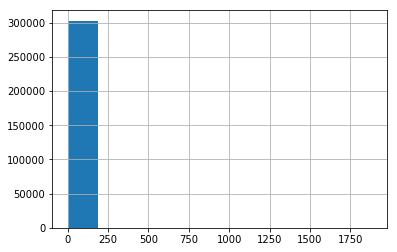

count    302989.000000
mean          2.524927
std           8.472599
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        1884.000000
dtype: float64


In [184]:
counts = pd.Series([v for k,v in counter.items()], index = [k for k,v in counter.items()])
counts.hist()

plt.show()
print(counts.describe())


In [185]:
counts[counts.argsort()[::-1]]
# 5984c6fbb6b113623d63851f
# 'способ производства инстант-порошка из растительного сырья'

5984c6fbb6b113623d63851f    1884
5984c297b6b11331626384f3    1298
5984b582b6b11303ba638525    1280
5984c11bb6b1131e66638511     859
5984b7d5b6b1132953638517     845
5984b97bb6b11340306384fd     797
5984b9fbb6b11348ac63852c     771
5984b808b6b1132b9a638514     700
5984be8bb6b1137ec063851e     694
5984b896b6b113354263853f     614
5984c477b6b113450263854b     591
5984c094b6b11319de638516     548
5984b694b6b113159e638510     529
5984bd8fb6b113730f638548     522
5984b7e9b6b1132a8563850f     518
5984bb4ab6b113587963852a     514
5984c472b6b113450863853a     509
5984c446b6b11343ad638544     501
5984c564b6b113508f638536     486
5984bcd7b6b11368ff63851f     484
5984c477b6b113450263854c     454
5984b960b6b1133ef1638517     445
5984c70bb6b113633c6384f6     431
5984ba88b6b1134d6d63851c     416
5984c711b6b113634963850a     416
5984bc90b6b11366a5638501     401
5984c283b6b1133010638549     382
5984be8bb6b1137ec063851d     377
5984bd80b6b1137302638501     372
5984c4b3b6b11347a2638503     353
          

# Save b560 valid links to mongo

In [3]:
client = MongoClient()
db = client.fips

In [ ]:
for k,v in tqdm(res.items()):
    db.patents.update_one({'_id': ObjectId(k)}, {"$set": {'similar':v}}, upsert=False)

In [7]:
# save to text file
topn = db.patents.find({'similar': {'$exists': True}}, 
                       {'similar': 1})

sims = {}
for doc in topn:
    sims[str(doc['_id'])] = doc['similar']

In [14]:
with open(join(DATA_FOLDER, 'sims.json'), 'w') as outfile:
    json.dump(sims, outfile, indent=5)

In [15]:
!head  {join(DATA_FOLDER, 'sims.json')} -n 100

{
     "5984b7c2b6b1132856638528": [
          "5984b65cb6b1131291638512"
     ],
     "5984b980b6b113401d638515": [
          "5984b65cb6b113129b638521"
     ],
     "5984b9f9b6b11348ca63850f": [
          "5984b71fb6b1131bef638550"
     ],
     "5984b9fab6b11348c163851e": [
          "5984b65ab6b113129b638508"
     ],
     "5984ba05b6b11348c1638540": [
          "5984b680b6b1131490638515"
     ],
     "5984ba11b6b11349ec6384f0": [
          "5984b688b6b113147e638533",
          "5984b5dbb6b1130839638502",
          "5984b832b6b1132dc8638509"
     ],
     "5984ba15b6b11349ee638507": [
          "5984b78bb6b113254c63852e"
     ],
     "5984ba15b6b11349ee638508": [
          "5984b584b6b11303c1638551"
     ],
     "5984ba17b6b11349f563850c": [
          "5984b787b6b113256063850b"
     ],
     "5984ba17b6b11349f563850d": [
          "5984b5ccb6b113073663853e"
     ],
     "5984ba17b6b11349f5638510": [
          "5984b653b6b11311c963852f"
     ],
     "5984ba1db6b11349ee63852c": [
       

# Get w2v

##### tokenize docs and save for fast access

In [4]:
client = MongoClient('fips')
db = client.fips

def json2text(doc, raw=False):
    text = ''
    prefix = '_raw' if raw else ''
    if 'name'+prefix in doc:
        text += doc['name'+prefix] + u'.\n'
    if 'abstract'+prefix in doc:
        text += doc['abstract'+prefix] + u'.\n'
    if 'description'+prefix in doc:
        text += doc['description'+prefix] + u'.\n'
    if 'claims'+prefix in doc:
        text += doc['claims'+prefix]

    return text

In [3]:
# db.patents.update_many({}, {'$unset': {'tokenized':1}})

In [3]:
docs_ids = [doc['_id'] for doc in db.patents.find({}, {'_id': 1}) ]

In [31]:
# db.corpus.update_one({'tokenized': 'simple'}, {'$set': {'docs':[]}})
import gc

def save_corpus(ids, prefix, raw=False):
    client = MongoClient('fips')
    db = client.fips
    
    raw_str = '_raw' if raw else ''
    docs = {}
    
    for _id in ids:
        doc_tokenized = []
        
        doc = db.patents.find_one({'_id': _id}, 
                                  {'name'+raw_str: 1, 'abstract'+raw_str: 1, 
                                   'description'+raw_str: 1, 'claims'+raw_str: 1})
        text = json2text(doc, raw)
        for sentence in nltk.sent_tokenize(text):
            tokenized_sent = list(tokenize(sentence, stop_list=simple_stop_list))
            if len(tokenized_sent) > 1:
                doc_tokenized.append(tokenized_sent)
        
        docs[str(_id)] = doc_tokenized
    
    folder = 'documents_raw' if raw else 'documents'
    fname = join(DATA_FOLDER, folder, '%s' % prefix + '.json.gz')
    with GzipFile(fname, 'w') as fout:
        json_str = json.dumps(docs)
        json_bytes = json_str.encode('utf-8')

        fout.write(json_bytes)
    gc.collect()

In [32]:
parallelizer = Parallel(n_jobs=2)

# this iterator returns the functions to execute for each task
tasks_iterator = ( delayed(save_corpus)(list_block, i, True) for 
                  i, list_block in enumerate(grouper(len(docs_ids)//1000, docs_ids)) ) 
result = parallelizer( tasks_iterator )

KeyboardInterrupt: 

In [ ]:
! echo 'finished json2text' >> ../data/out

##### check

In [15]:
pprint(json2text(db.patents.find_one({'_id': docs_ids[33]})))

('запоминать устройство и способ управление он\n'
 '.\n'
 ' изобретение относиться к электронный техника и мочь быть использовать при '
 'создание интегральный \n'
 '\n'
 'микросхема запоминать устройство (зу) с энергонезависимый хранение '
 'информация.  известный запоминать устройство (зу), содержать схема '
 'управление и накопитель на мдп-транзистор с \n'
 '\n'
 'изменять порог на основа двуслойный диэлектрик, выполнять на эпитаксиальный '
 'пленка полупроводник, где запись и стирание осуществляться подача импульс '
 'напряжение на полевой электрод и \n'
 '\n'
 'подложка.  его недостаток являться малый плотность компоновка ячейка память '
 'вследствие разделение подложка элемент память в строка, малый время хранение '
 'информация из-за \n'
 'использование \n'
 'туннельный-прозрачный слой окисел как для электрон, так и для дырка, а также '
 'сложность схема управление, поскольку в данный зу необходимо подавать '
 'высоковольтный импульс запись и \n'
 'стирание как на \n'
 'полевой 

In [16]:
fn = join(DATA_FOLDER, 'documents/0.json.gz')

with GzipFile(fn, 'r') as myzip:
    text = myzip.read()
docs = json.loads(text)
docs[str(docs_ids[33])]


[['запоминать', 'устройство', 'способ', 'управление'],
 ['изобретение',
  'относиться',
  'электронный',
  'техника',
  'мочь',
  'использовать',
  'создание',
  'интегральный',
  'микросхема',
  'запоминать',
  'устройство',
  'зу',
  'энергонезависимый',
  'хранение',
  'информация'],
 ['известный',
  'запоминать',
  'устройство',
  'зу',
  'содержать',
  'схема',
  'управление',
  'накопитель',
  'мдп',
  'транзистор',
  'изменять',
  'порог',
  'основа',
  'двуслойный',
  'диэлектрик',
  'выполнять',
  'эпитаксиальный',
  'пленка',
  'полупроводник',
  'запись',
  'стирание',
  'осуществляться',
  'подача',
  'импульс',
  'напряжение',
  'полевой',
  'электрод',
  'подложка'],
 ['недостаток',
  'являться',
  'малый',
  'плотность',
  'компоновка',
  'ячейка',
  'память',
  'вследствие',
  'разделение',
  'подложка',
  'элемент',
  'память',
  'строка',
  'малый',
  'время',
  'хранение',
  'информация',
  'использование',
  'туннельный',
  'прозрачный',
  'слой',
  'окисел',
  'эле

In [2]:
ziped_files = sorted(glob(DATA_FOLDER + '/documents/*.gz'), key=natural_keys)

In [2]:
# len(s) > 1 !!!!!!!!
def get_len(list_gz):
    unpacked_list =[json.loads(GzipFile(fn, 'r').read()) for fn in tqdm(list_gz)]
    lens = [[len(s) for s in doc if len(s) > 1] for docs in unpacked_list for k,doc in docs.items()]
    return lens

parallelizer = Parallel(n_jobs=cpu_count)

# this iterator returns the functions to execute for each task
tasks_iterator = ( delayed(get_len)(list_gz) for 
                  list_gz in grouper(1, ziped_files) ) 
result = parallelizer( tasks_iterator )

In [12]:
concated = sum(result, [])

In [5]:
len(concated)

1266940

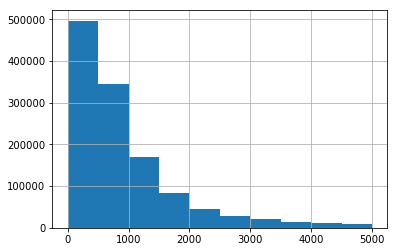

count    1.266940e+06
mean     1.181864e+03
std      2.160956e+03
min      0.000000e+00
25%      2.280000e+02
50%      6.760000e+02
75%      1.275000e+03
max      1.290420e+05
dtype: float64

In [6]:
# number of words in each document
words_per_doc = [sum(d) for d in concated]
words_per_doc = pd.Series(words_per_doc)

words_per_doc[words_per_doc<5000].hist()
plt.show()
words_per_doc.describe()

In [7]:
from scipy.stats.mstats import mquantiles

# number of words in each sentence
mquantiles([s for d in concated for s in d], prob=[0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99])

array([   3.,    5.,    6.,    8.,    9.,   14.,   23.,   26.,   31.,
         38.,   54.,  113.])

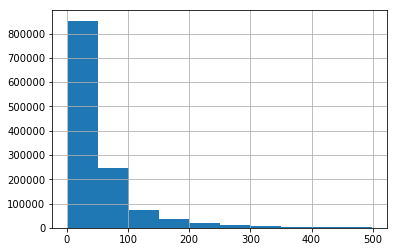

count    1.266897e+06
mean     5.758952e+01
std      1.071420e+02
min      1.000000e+00
25%      1.000000e+01
50%      3.300000e+01
75%      6.300000e+01
max      5.958000e+03
dtype: float64

In [15]:
# number of sentences in each document
sents = pd.Series([len(d) for d in concated if len(d)])

sents[sents<500].hist()
plt.show()
sents.describe()

In [16]:
mquantiles(sents, prob=[0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99])

array([   2.,    2.,    4.,    6.,   10.,   33.,   63.,   75.,   92.,
        123.,  194.,  456.])

##### w2v algo

In [18]:
# iter only over 

class Sentences(object):
    def __init__(self, folder):
        self.folder = folder
 
    def __iter__(self):
        for fn in glob(join(self.folder, '*.gz')):
            with GzipFile(fn, 'r') as myzip:
                text = myzip.read()
            docs = json.loads(text)
            for k, doc in docs.items():
                for sentence in doc:
                    yield sentence

In [3]:
dim = 300
model = Word2Vec(Sentences(join(DATA_FOLDER, 'documents/')), size=dim, 
                 sg=1, min_count=5, window=10, workers=cpu_count)

In [ ]:
! mkdir -p {join(DATA_FOLDER, 'vectors/')}

In [ ]:
model_name = 'saved/w2v_model_%s_w10' % dim
model.save(join(DATA_FOLDER, model_name))

2017-08-11 14:21:27,509 : INFO : saving Word2Vec object under ../data/saved/w2v_model_300_w10, separately None
2017-08-11 14:21:27,510 : INFO : storing np array 'syn0' to ../data/saved/w2v_model_300_w10.wv.syn0.npy
2017-08-11 14:21:27,988 : INFO : not storing attribute syn0norm
2017-08-11 14:21:27,990 : INFO : storing np array 'syn1neg' to ../data/saved/w2v_model_300_w10.syn1neg.npy
2017-08-11 14:21:28,607 : INFO : not storing attribute cum_table
2017-08-11 14:21:31,741 : INFO : saved ../data/saved/w2v_model_300_w10


In [ ]:
! echo 'finished w2v' >> ../data/out

In [27]:
model.wv.most_similar(positive=['помидор'], topn=10)

[('томат', 0.6997999548912048),
 ('тушеный', 0.6983544230461121),
 ('овощ', 0.6927006244659424),
 ('брокколи', 0.6787952184677124),
 ('овощной', 0.670366108417511),
 ('капуста', 0.669182538986206),
 ('баклажан', 0.6668474078178406),
 ('винегрет', 0.6571622490882874),
 ('цуккини', 0.6525208353996277),
 ('салат', 0.65178382396698)]

# Save indices as plain text

In [17]:
ziped_files = sorted(glob(DATA_FOLDER + '/documents/*.gz'), key=natural_keys)

In [18]:
w2v_model = Word2Vec.load(join(DATA_FOLDER, 'vectors/w2v_model_300_w10'))
wv = w2v_model.wv

2017-08-31 15:30:40,247 : INFO : loading Word2Vec object from ../data/vectors/w2v_model_300_w10
2017-08-31 15:30:42,656 : INFO : loading wv recursively from ../data/vectors/w2v_model_300_w10.wv.* with mmap=None
2017-08-31 15:30:42,657 : INFO : loading syn0 from ../data/vectors/w2v_model_300_w10.wv.syn0.npy with mmap=None
2017-08-31 15:30:46,080 : INFO : setting ignored attribute syn0norm to None
2017-08-31 15:30:46,081 : INFO : loading syn1neg from ../data/vectors/w2v_model_300_w10.syn1neg.npy with mmap=None
2017-08-31 15:30:49,561 : INFO : setting ignored attribute cum_table to None
2017-08-31 15:30:49,562 : INFO : loaded ../data/vectors/w2v_model_300_w10


In [19]:
# add 1 to each index to denote 0 index as <PAD> symbol
def save_indices(ziped_files, wv):
    client = MongoClient()
    collection = client.fips.patents

    for fn in tqdm(ziped_files):
        with GzipFile(fn, 'r') as gzf:
            text = gzf.read()
        docs = json.loads(text)
        for _id,doc in docs.items():
            ixs = [[str(wv.vocab[w].index+1) for w in sent[:40] if w in wv] for sent in doc]
            ixs = [s for s in ixs if len(s) > 1][:123]
            with open(join(DATA_FOLDER, 'corpus/%s.txt'%_id), 'w') as f:
                f.writelines([' '.join(sent) + '\n' for sent in ixs])
            
#             ixs = tflearn.data_utils.pad_sequences(ixs, 40)
#             np.savetxt(join(DATA_FOLDER, 'corpus/%s.csv'%_id), ixs, fmt='%d')
#             with open(join(DATA_FOLDER, 'corpus/%s.json'%_id), 'w') as f:
#                 f.write(json.dumps(ixs, separators=(',', ':')))
#             collection.update({'_id', ObjectId(_id)}, {"$set": {'ixs': ixs}}, upsert=False)

In [20]:
save_indices(ziped_files, wv)

100%|██████████| 1001/1001 [1:26:02<00:00,  6.16s/it]


# Draft

In [2]:
client = MongoClient('fips')
db = client.fips

In [10]:
top10 = db.patents.find({'similar': {'$elemMatch': {'$eq':'5984c6fbb6b113623d63851f' }}}, {'_id':1})
for doc in top10:
    print(doc)

{u'_id': ObjectId('5984c968b6b1137bd26384ee')}
{u'_id': ObjectId('5984c968b6b1137bd26384ef')}
{u'_id': ObjectId('5984c968b6b1137bd26384f1')}
{u'_id': ObjectId('5984c968b6b1137bd26384f2')}
{u'_id': ObjectId('5984c968b6b1137bd26384f3')}
{u'_id': ObjectId('5984c968b6b1137bd26384f4')}
{u'_id': ObjectId('5984c968b6b1137bd26384f5')}
{u'_id': ObjectId('5984c968b6b1137bd26384f6')}
{u'_id': ObjectId('5984c968b6b1137bd26384f7')}
{u'_id': ObjectId('5984c969b6b1137bd26384f8')}
{u'_id': ObjectId('5984c969b6b1137bd26384f9')}
{u'_id': ObjectId('5984c969b6b1137bd26384fa')}
{u'_id': ObjectId('5984c969b6b1137bd26384fb')}
{u'_id': ObjectId('5984c969b6b1137bd26384fc')}
{u'_id': ObjectId('5984c969b6b1137bd26384fe')}
{u'_id': ObjectId('5984c96ab6b1137bd26384ff')}
{u'_id': ObjectId('5984c96ab6b1137bd2638501')}
{u'_id': ObjectId('5984c96ab6b1137bd2638502')}
{u'_id': ObjectId('5984c96ab6b1137bcc6384fd')}
{u'_id': ObjectId('5984c96ab6b1137bd2638503')}
{u'_id': ObjectId('5984c96ab6b1137bd2638504')}
{u'_id': Obje

{u'_id': ObjectId('5984cbf5b6b11318b26384ee')}
{u'_id': ObjectId('5984cbf6b6b11318b26384ef')}
{u'_id': ObjectId('5984cbf6b6b11318b26384f0')}
{u'_id': ObjectId('5984cbf7b6b11318b26384f1')}
{u'_id': ObjectId('5984cbf7b6b11318b26384f2')}
{u'_id': ObjectId('5984cbf7b6b11318b26384f3')}
{u'_id': ObjectId('5984cbf8b6b11318b26384f4')}
{u'_id': ObjectId('5984cbf9b6b11318b26384f5')}
{u'_id': ObjectId('5984cbfab6b11318b26384f6')}
{u'_id': ObjectId('5984cbfab6b11318b26384f7')}
{u'_id': ObjectId('5984cbfab6b11318b26384f8')}
{u'_id': ObjectId('5984cbfbb6b11318b26384f9')}
{u'_id': ObjectId('5984cbfcb6b11318b26384fa')}
{u'_id': ObjectId('5984cbfcb6b11318b26384fb')}
{u'_id': ObjectId('5984cbfcb6b11318b26384fc')}
{u'_id': ObjectId('5984cbfcb6b11318b26384fd')}
{u'_id': ObjectId('5984cbfdb6b11318b26384fe')}
{u'_id': ObjectId('5984cbfdb6b11318b2638500')}
{u'_id': ObjectId('5984cd46b6b113223f6384ee')}
{u'_id': ObjectId('5984cd46b6b113223f6384ef')}
{u'_id': ObjectId('5984cd46b6b113223f6384f0')}
{u'_id': Obje

# Similarity Graph

In [69]:
import networkx as nx

simG = nx.DiGraph()

client = MongoClient('fips')
db = client.fips

topn = db.patents.find({'similar': {'$exists': True}}, 
                       {'similar': 1})
parents = []
for doc in tqdm(topn):
    _id = unicode(doc['_id'])
    parents.append(_id)
    for sim in doc['similar']:
        simG.add_edge(_id, sim)


0it [00:00, ?it/s]

1it [00:13, 13.95s/it]
102it [01:02,  9.91s/it]
5278it [01:02,  6.94s/it]
11394it [01:02,  4.86s/it]
18042it [01:02,  3.40s/it]
22099it [01:02,  2.38s/it]
27953it [01:02,  1.67s/it]
32541it [01:02,  1.17s/it]
37368it [01:02,  1.23it/s]
42285it [01:02,  1.75it/s]
47004it [01:03,  2.50it/s]
52045it [01:03,  3.57it/s]
56808it [01:03,  5.10it/s]
61509it [01:03,  7.29it/s]
66062it [01:03, 10.41it/s]
70954it [01:03, 14.87it/s]
75590it [01:03, 21.25it/s]
80293it [01:03, 30.35it/s]
84953it [01:03, 43.34it/s]
89606it [01:03, 61.89it/s]
94185it [01:04, 88.36it/s]
98704it [01:04, 126.10it/s]
104030it [01:04, 179.96it/s]
108628it [01:04, 256.65it/s]
113219it [01:04, 365.75it/s]
117807it [01:04, 520.72it/s]
122456it [01:04, 740.34it/s]
127124it [01:04, 1050.48it/s]
131740it [01:04, 1485.83it/s]
136322it [01:04, 2092.80it/s]
140871it [01:05, 2931.33it/s]
145469it [01:05, 4076.23it/s]
151081it [01:05, 5647.36it/s]
156150it [01:05, 7699.90it/s]
156150it [01:21, 1904.93it/s]
156342

In [102]:
with open(join(DATA_FOLDER, 'sim.graph'), 'wb') as f:
    pickle.dump(simG, f)

In [12]:
graphs = list(nx.weakly_connected_component_subgraphs(simG))
nodes = [g.nodes() for g in graphs]

In [13]:
lens = pd.Series([len(g) for g in nodes])

In [14]:
lens.describe()

count     32322.000000
mean         16.821143
std        2449.573337
min           2.000000
25%           2.000000
50%           2.000000
75%           3.000000
max      440395.000000
dtype: float64

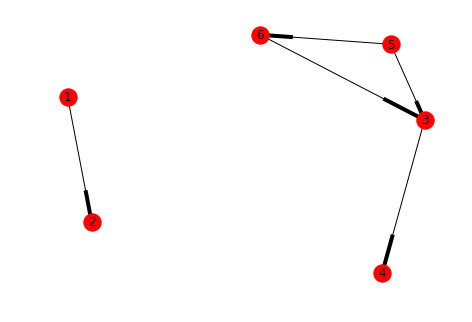

In [103]:
g = nx.DiGraph()

g.add_edge(1,2)
g.add_edge(1,2)
g.add_edge(3,4)
g.add_edge(5,6)
g.add_edge(6,3)
g.add_edge(5,3)

nx.draw(g, with_labels=True)
plt.show()

In [104]:
graphs = nx.weakly_connected_component_subgraphs(g)
[g.nodes() for g in graphs]

[[1, 2], [3, 4, 5, 6]]

In [6]:
reachable = []
for node in tqdm(parents):
    desc = nx.descendants(simG, node)
    reachable.append(len(desc))

100%|██████████| 368458/368458 [00:05<00:00, 64765.29it/s]


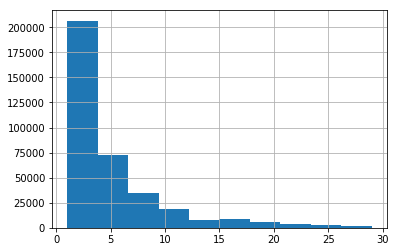

count    368458.000000
mean          5.609823
std           9.944948
min           1.000000
25%           1.000000
50%           3.000000
75%           6.000000
max         547.000000
dtype: float64

In [10]:
reachable = pd.Series(reachable)
reachable[reachable<30].hist()
plt.show()
reachable.describe()

# MPK Graph

In [2]:
def fix(name):
    fixes = {u'\u041d':u'H', u'\u0410':u'A', u'\u0412':u'B'}
    if name in fixes:
        return fixes[name]
    else:
        return name

In [3]:
def nameit(tag, el, use_prefix = True):
    if use_prefix:
        name = '%s_%s' % (tag, fix(el[tag]))
    else:
        name = '%s' % fix(el[tag])
    return name

In [4]:
mpkG = nx.DiGraph()

client = MongoClient('fips')
db = client.fips

topn = db.patents.find({'mpk': {'$exists': True}}, 
                       {'mpk': 1})
way = ['section', 'class', 'subclass', 'main-group', 'subgroup']
for doc in tqdm_notebook(topn):
    _id = unicode(doc['_id'])
    for el in doc['mpk']:
        mpkG.add_edge('ROOT', nameit('section', el))
        for left, right in zip(way[:-1], way[1:]):
            if left in el and right in el:
                mpkG.add_edge(nameit(left, el), nameit(right, el))
            else: break
        if len(el):
            mpkG.add_edge(nameit(left, el), _id)        

1267180it [05:17, 3988.69it/s] 1071963it [04:32, 3926.95it/s]


In [ ]:
mpkG = nx.DiGraph()

client = MongoClient('fips')
db = client.fips

topn = db.patents.find({'mpk': {'$exists': True}}, 
                       {'mpk': 1})
way = ['section', 'class_', 'subclass', 'main_group', 'subgroup']
for doc in tqdm_notebook(topn):
    doc = rename(doc)
    doc['mpk'] = [clean_mpk(mpk) for mpk in doc['mpk']]
    for mpk in doc['mpk']:
        prev = fix(mpk['section'])
        mpkG.add_edge('ROOT', prev)
        for right in way[1:]:
            if right in mpk:
                new_prev = '%s_%s' % (prev, fix(mpk[right]))
                mpkG.add_edge(prev, new_prev)
                prev = new_prev
            else: break
        if len(mpk):
            mpkG.add_edge(prev, str(doc['_id']))        

691476it [03:01, 3817.51it/s]

KeyboardInterrupt: 

In [7]:
with open(join(DATA_FOLDER, 'mpk.graph'), 'wb') as f:
    pickle.dump(mpkG, f)

In [4]:
with open(join(DATA_FOLDER, 'mpk.graph'), 'rb') as f:
    mpkG = pickle.load(f)

In [20]:
nbunch = [x for x in mpkG.nodes_iter() if mpkG.out_degree(x)>0 and 
          len(x.split('_'))<5]
# print(nbunch)

In [21]:
sub_mpk = mpkG.subgraph(nbunch)
display_nodes = {
    n: n.split('_')[1]
    for n in sub_mpk.nodes()
    if n.startswith(('section', 'class_', 'subclass')) # 'main-group'
}
display_nodes.update({'ROOT':'ROOT'})

In [22]:
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

write_dot(sub_mpk,'mpk.dot')
# dot -Tps mpk.dot -o mpk.ps

In [23]:
plt.clf()
pos = graphviz_layout(sub_mpk, prog='dot')
# nx.draw_networkx_labels(sub_mpk,pos=pos, labels=display_nodes, font_size=3)
nx.draw(sub_mpk, pos, with_labels=False, arrows=False, 
        node_size=1, width=0.1, labels=None, alpha=0.5)
plt.savefig('mpk_small.png', dpi=500)

![mpk.png](mpk.png)

All levels except the last one

![mpk_small.png](mpk_small.png)

In [4]:
unique_mpkG = nx.DiGraph()

client = MongoClient('fips')
db = client.fips

topn = db.patents.find({'mpk': {'$exists': True}}, 
                       {'mpk': 1})
way = ['section', 'class', 'subclass', 'main-group', 'subgroup']
for doc in tqdm(topn):
    _id = unicode(doc['_id'])
    for el in doc['mpk']:
        unique_path = 'ROOT'
        for name in way:
            if name in el:
                unique_path += '/' + nameit(name, el, use_prefix = False)
            else: break
        if len(el):
            unique_mpkG.add_edge(unique_path, _id)

1267180it [03:51, 5474.77it/s] 


In [104]:
with open(join(DATA_FOLDER, 'unique_mpk.graph'), 'wb') as f:
    pickle.dump(unique_mpkG, f)

In [5]:
nbunch = [x for x in unique_mpkG.nodes_iter() if unique_mpkG.out_degree(x)>0]
print(len(nbunch))
nbunch[:10]

60130


[u'ROOT/F/02/B/27/02',
 u'ROOT/F/02/B/27/00',
 u'ROOT/F/02/B/27/04',
 u'ROOT/C/07/J/9/00',
 u'ROOT/A/62/B/31/00',
 u'ROOT/C/07/D/495/16',
 u'ROOT/C/07/D/495/14',
 u'ROOT/C/07/D/495/12',
 u'ROOT/C/07/D/495/10',
 u'ROOT/G/01/F/5/00']

In [11]:
lens = []
for node in tqdm(nbunch):
    if node == 'ROOT':
        continue
    desc = nx.descendants(unique_mpkG, node)
    lens.append(len(desc))

100%|██████████| 60130/60130 [00:04<00:00, 12826.62it/s]


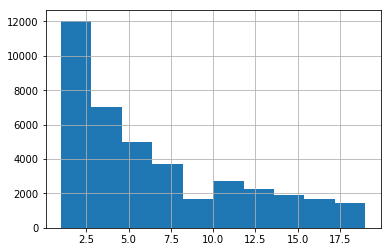

count    60130.000000
mean        38.272011
std        132.370708
min          1.000000
25%          3.000000
50%         10.000000
75%         31.000000
max       8713.000000
dtype: float64

In [13]:
lens = pd.Series(lens)
lens[lens<20].hist()
plt.show()
lens.describe()

In [10]:
nbunch[np.argmax(lens)]

u'ROOT/A/61/B/17/00'

In [14]:
len(lens[lens==1])

7067

In [8]:
def mpk_neighbours(unique_mpkG, _id):
    """
    Returns document neighbours relative to full MPK path
    """
    _id = str(_id)
    parents = nx.ancestors(unique_mpkG, _id)
    neibs = set()
    for node in parents:
        desc = nx.descendants(unique_mpkG, node)
        neibs.update(desc)
    neibs.remove(_id)
    return neibs

In [33]:
ids = [x for x in unique_mpkG.nodes_iter() if unique_mpkG.out_degree(x)==0]

In [9]:
def get_lens(ids):
    lens = []
    for _id in ids:
        ns = mpk_neighbours(unique_mpkG, _id)
        lens.append(len(ns))
        
        l = len(lens)
        if len(lens) % 10000 == 0:
            print(l)
        
    return lens

In [48]:
parallelizer = Parallel(n_jobs=cpu_count)

# this iterator returns the functions to execute for each task
tasks_iterator = ( delayed(get_lens)(docs_block) for 
                  docs_block in grouper(len(ids)//cpu_count, ids) )
result = parallelizer( tasks_iterator )        
lens = sum(result, [])

10000
10000
10000
10000
20000
20000
20000
20000
30000
30000
30000
30000
40000
40000
40000
40000
50000
50000
50000
50000
60000
60000
60000
60000
70000
70000
70000
70000
80000
80000
80000
80000
90000
90000
90000
90000
100000
100000
100000
100000
110000
110000
110000
110000
120000
120000
120000
120000
130000
130000
130000
130000
140000
140000
140000
140000
150000
150000
150000
150000
160000
160000
160000
160000
170000
170000
170000
170000
180000
180000
180000
180000
190000
190000
190000
190000
200000
200000
200000
200000
210000
210000
210000
210000
220000
220000
220000
220000
230000
230000
230000
230000
240000
240000
240000
240000
250000
250000
250000
260000
250000
260000
260000
270000
260000
270000
270000
280000
270000
280000
280000
290000
280000
290000
290000
300000
290000
300000
300000
310000
300000
310000
310000
310000


TypeError: unsupported operand type(s) for +: 'int' and 'list'

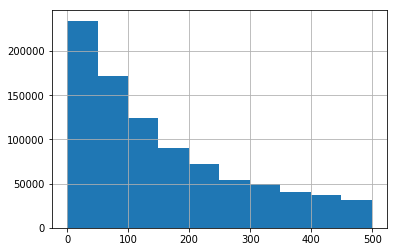

count    1.267180e+06
mean     8.272082e+02
std      1.796766e+03
min      0.000000e+00
25%      7.100000e+01
50%      2.090000e+02
75%      6.030000e+02
max      3.814700e+04
dtype: float64

In [64]:
lens = pd.Series(lens)
lens[lens<500].hist()
plt.show()
lens.describe()

In [63]:
100*float(len(lens[lens==0]))/len(lens)

0.21165106772518505

# Compose train/test data using Graphs information

In [ ]:
with open(join(DATA_FOLDER, 'sim.graph'), 'rb') as f:
    simG = pickle.load(f)
    
with open(join(DATA_FOLDER, 'unique_mpk.graph'), 'rb') as f:
    unique_mpkG = pickle.load(f)

In [32]:
all_ids = [x for x in unique_mpkG.nodes_iter() if unique_mpkG.out_degree(x)==0]

### example

In [83]:
sim_ids = [x for x in simG.nodes_iter() if simG.out_degree(x)==0]

In [94]:
_id = sim_ids[31]
_id

u'5984b8c9b6b1133836638515'

In [95]:
neibs = mpk_neighbours(unique_mpkG, _id)
neibs

{u'5984b5a6b6b1130596638545',
 u'5984b5eeb6b11309556384f1',
 u'5984b5eeb6b11309556384f2',
 u'5984b606b6b1130a7c638505',
 u'5984b63eb6b1130e3f638537',
 u'5984b643b6b1130f2c638512',
 u'5984b644b6b1130f21638550',
 u'5984b653b6b11311c1638515',
 u'5984b696b6b11315a2638515',
 u'5984b696b6b11315a2638516',
 u'5984b6d9b6b11318a9638530',
 u'5984b6e8b6b11319c76384f4',
 u'5984b7a0b6b11326776384fb',
 u'5984b7d4b6b113296e638522',
 u'5984b84bb6b1132ee0638516',
 u'5984b84bb6b1132ee0638517',
 u'5984b88cb6b1133479638502',
 u'5984b88db6b113346a638512',
 u'5984b89db6b113362f638505',
 u'5984b89db6b113362f638506',
 u'5984b89db6b113362f63850f',
 u'5984b8a5b6b11337126384ee',
 u'5984b941b6b1133db4638517',
 u'5984b96ab6b1133efe638544',
 u'5984b97ab6b11340146384f3',
 u'5984b99ab6b11341376384f8',
 u'5984b9a0b6b113414363853b',
 u'5984b9a8b6b1134136638551',
 u'5984b9b0b6b113425663854b',
 u'5984b9b9b6b113432f638512',
 u'5984b9b9b6b1134341638514',
 u'5984b9f6b6b11348b2638511',
 u'5984ba14b6b11349de6384fd',
 u'5984ba1

In [129]:
sims = nx.all_neighbors(simG, _id)
list(sims)

[u'5984bf57b6b1130792638549', u'5984b81ab6b1132ca66384fc']

### func

In [78]:
client = MongoClient('fips')
db = client.fips

topn = list(db.patents.find({'similar': {'$exists': True}}, 
                       {'similar': 1}))

In [5]:
def inrad2(simG, _id):
    neibs = set()
    sims = set(nx.all_neighbors(simG, _id))
    neibs.update(sims)
    for nb in sims:
        neibs.update(set(nx.all_neighbors(simG, nb)))
    neibs.remove(_id)
    return neibs

In [131]:
inrad2(simG, '5984ba11b6b11349ec6384f0')

{u'5984b5dbb6b1130839638502',
 u'5984b688b6b113147e638533',
 u'5984b699b6b11315a5638536',
 u'5984b832b6b1132dc8638509',
 u'5984ba00b6b11348be63853e',
 u'5984bb49b6b113587c638534',
 u'5984bb6eb6b11359b363852c',
 u'5984bb79b6b11359b7638544',
 u'5984bbffb6b1135eac6384f9',
 u'5984bc63b6b1136471638540',
 u'5984bc70b6b11365a0638503',
 u'5984bc70b6b11365a0638504',
 u'5984bcb0b6b11367e0638513',
 u'5984bcd2b6b11368ec638528',
 u'5984bdb0b6b113743963853c',
 u'5984befab6b11303e6638528',
 u'5984bf78b6b11308f2638519',
 u'5984c3abb6b1133f01638514',
 u'5984c531b6b1134f6d638511',
 u'5984c78bb6b11367b463854d',
 u'5984c7edb6b1136a97638505',
 u'5984c93cb6b11379aa638516',
 u'5984c96eb6b1137bca638509',
 u'5984cf05b6b1132e736384ff',
 u'5984dca0b6b1132dda638512',
 u'5984dca6b6b1132dda638526',
 u'5984dce8b6b113302963853f',
 u'5984dea7b6b1133b5b638506',
 u'5984ded8b6b1133b6063853c'}

In [116]:
from tqdm import tqdm_notebook

import random
random.seed(0)

"""
For each query having similar docs make 2 triples:
    [query, positive, negative but having same MPK path]
    [query, positive, random doc from all corpus except similar to query and not having same MPK path]
    and choose at random only one
    
    positive doc is a doc that was directly marked by human as similar to query
    similar docs are distant from query by radius 2 without considering direction in similarity graph
"""

def compose(docs):
    for doc in tqdm_notebook(docs):
        _id = unicode(doc['_id'])
        if _id not in unique_mpkG:
            print('%s not in unique_mpkG' % _id)
            continue

        # sims are similar in radius 2 without considering direction
        sims = inrad2(simG, _id)
        neibs = mpk_neighbours(unique_mpkG, _id)
        diff = neibs.difference(sims)
        for pos in doc['similar']:
            if np.random.choice([0,1], p=[0.5,0.5]):                
                if len(diff) == 0:
                    neg_mpk = random.sample(all_ids, 1)[0]
                    while neg_mpk in neibs.union(sims):
                        neg = random.sample(all_ids, 1)[0]
                else:
                    neg_mpk = random.sample(diff, 1)[0]
                    diff.remove(neg_mpk)
                yield [_id, pos, neg_mpk]
            else:
                neg = random.sample(all_ids, 1)[0]
                while neg in sims or neg in neibs:
                    neg = random.sample(all_ids, 1)[0]                    
                yield [_id, pos, neg]

In [117]:
num_epochs = 3

fname = join(DATA_FOLDER, 'mpk_flow.csv.gz')
!rm -f {fname}

for ep in range(num_epochs):
    flow = compose(topn)
    with GzipFile(fname, 'awb') as f:
        for triples in grouper(5000, flow):   
            chunk = ''
            for t in triples:
                chunk += '%s %s %s\n' % tuple(t)
            f.write(chunk)

5984d4bbb6b11366c0638531 not in unique_mpkG



5984d4bbb6b11366c0638531 not in unique_mpkG



5984d4bbb6b11366c0638531 not in unique_mpkG



In [73]:
3*1.5*1200000/2000

2700.0

In [ ]:
!echo 'finished' > 'out'

In [ ]:
!cat out

In [66]:
!head -n 100 {fname}

# Sync ids

In [62]:
def conv(s):
    a, b, c = s.split('.')
    return ''.join([c, b, a])

def zfill(s):
    return s.zfill(10)

def unify(s):
    return s.strip().upper()

In [63]:
ids = np.load('../data/saved/fnames_1ep_0.5.npy')

In [64]:
df = pd.concat([pd.read_csv(fn, sep=';', dtype=str) for fn in glob('../data/ru_export/*')])
df.rename(columns={'DOC_NUMBER':'doc-number', 'KIND':'kind', 
                   'COUNTRY':'country', 'DATE_PUBL': 'date-publ'}, inplace=True)

In [65]:
df['date-publ'] = df['date-publ'].apply(conv)
df['doc-number'] = df['doc-number'].apply(zfill)
df['kind'] = df['kind'].apply(unify)
df['country'] = df['country'].apply(unify)

In [66]:
subset = df[['country', 'doc-number', 'kind']]
tuples = [tuple(x) for x in subset.values]
index = pd.MultiIndex.from_tuples(tuples, names=['country', 'doc-number', 'kind'])

In [67]:
i_df = pd.DataFrame(df['R_OBJECT_ID'].values, index = index, columns=['_id'])
i_df.sort_index(inplace=True)

In [82]:
len(ids)

1267008

In [68]:
len(df)-len(ids)

79783

In [69]:
i_df

_id
country doc-number kind                  
RU      0000000001 U1    09000001808a479a
        0000000002 U1    09000001808a4799
        0000000003 U1    09000001808a4798
        0000000004 U1    09000001808a4797
        0000000005 U1    09000001808a4796
        0000000006 U1    09000001808a4795
        0000000007 U1    09000001808a4794
        0000000008 U1    09000001808a4793
        0000000009 U1    09000001808a4792
        0000000010 U1    09000001808a4791
        0000000011 U1    09000001808a4790
        0000000012 U1    09000001808a478f
        0000000013 U1    09000001808a478e
        0000000014 U1    09000001808a478d
        0000000015 U1    09000001808a478c
        0000000016 U1    09000001808a478b
        0000000017 U1    09000001808a478a
        0000000018 U1    09000001808a4789
        0000000019 U1    09000001808a4788
        0000000020 U1    09000001808a4787
        0000000021 U1    09000001808a4786
        0000000022 U1    09000001808a4785
        0000000023 U1    09000001808a4784
        0000000024 U1    09000001808a4783
        0000000025 U1    09000001808a4782
        0000000026 U1    09000001808a4781
        0000000027 U1    09000001808a4780
        0000000028 U1    09000001808a477f
        0000000029 U1    09000001808a477e
        0000000030 U1    09000001808a477d
...                                   ...
SU      0001841241 A1    090000018815be16
        0001841242 A1    090000018815be17
        0001841243 A1    090000018815be18
        0001841244 A1    090000018815be19
        0001841245 A1    090000018815be1a
        0001841246 A1    090000018815b18f
        0001841247 A1    090000018815b575
        0001841248 A1    090000018815b576
        0001841249 A1    090000018815b577
        0001841250 A1    090000018815b578
        0001841251 A1    090000018815b579
        0001841252 A1    090000018815b57a
        0001841253 A1    090000018815b57b
        0001841254 A1    090000018815b57c
        0001841255 A1    090000018815b57d
        0001841256 A1    090000018815b57e
        0001841257 A1    090000018815b57f
        0001841258 A1    090000018815b580
        0001841259 A1    090000018815b581
        0001841260 A1    090000018815b582
        0001841261 A1    090000018815b583
        0001841262 A1    090000018815b584
        0001841263 A1    090000018815b585
        0001841264 A2    090000018815b58c
        0001841265 A1    090000018815b586
        0001841266 A1    090000018815b587
        0001841267 A1    090000018815b588
        0001841268 A1    090000018815b589
        0001841269 A1    090000018815b58a
        0001841270 A1    090000018815b58b

[1346791 rows x 1 columns]

In [70]:
tuples = [(v['country'].strip(), v['doc-number'], v['kind'].strip()) for v in docs.values()]
index = pd.MultiIndex.from_tuples(tuples, names=['country', 'doc-number', 'kind'])

In [72]:
docs_df = pd.DataFrame(docs.keys(), index = index, columns=['_id'])
docs_df.sort_index(inplace=True)

In [73]:
docs_df

_id
country doc-number kind                          
RU      0000000001 U1    5984b623b6b1130b7e63850f
        0000000002 U1    5984b623b6b1130b7e638510
        0000000003 U1    5984b623b6b1130b7e638511
        0000000004 U1    5984b623b6b1130b7e638512
        0000000005 U1    5984b624b6b1130b7e638513
        0000000006 U1    5984b624b6b1130b7e638514
        0000000007 U1    5984b624b6b1130b7e638515
        0000000008 U1    5984b624b6b1130b7e638516
        0000000009 U1    5984b624b6b1130b7e638517
        0000000010 U1    5984b624b6b1130b7e638518
        0000000011 U1    5984b624b6b1130b7e638519
        0000000012 U1    5984b624b6b1130b7e63851a
        0000000013 U1    5984b624b6b1130b7e63851b
        0000000014 U1    5984b624b6b1130b7e63851c
        0000000015 U1    5984b624b6b1130b7e63851d
        0000000016 U1    5984b625b6b1130b7e63851e
        0000000017 U1    5984b625b6b1130b7e63851f
        0000000018 U1    5984b625b6b1130b7e638520
        0000000019 U1    5984b625b6b1130b7e638521
        0000000020 U1    5984b625b6b1130b7e638522
        0000000021 U1    5984b625b6b1130b7e638523
        0000000022 U1    5984b625b6b1130b7e638524
        0000000023 U1    5984b625b6b1130b7e638525
        0000000024 U1    5984b625b6b1130b7e638526
        0000000025 U1    5984b625b6b1130b7e638527
        0000000026 U1    5984b625b6b1130b7e638528
        0000000027 U1    5984b625b6b1130b7e638529
        0000000028 U1    5984b625b6b1130b7e63852a
        0000000029 U1    5984b625b6b1130b7e63852b
        0000000030 U1    5984b625b6b1130b7e63852c
...                                           ...
SU      0001841241 A1    5984df40b6b1133fa963852f
        0001841242 A1    5984df40b6b1133fa9638530
        0001841243 A1    5984df40b6b1133fa9638531
        0001841244 A1    5984df40b6b1133fa9638532
        0001841245 A1    5984df41b6b1133fa9638533
        0001841246 A1    5984df41b6b1133fa9638534
        0001841247 A1    5984df41b6b1133fa9638535
        0001841248 A1    5984df41b6b1133fa9638536
        0001841249 A1    5984df41b6b1133fa9638537
        0001841250 A1    5984df41b6b1133fa9638538
        0001841251 A1    5984df41b6b1133fa9638539
        0001841252 A1    5984df41b6b1133fa963853a
        0001841253 A1    5984df41b6b1133fa963853b
        0001841254 A1    5984df41b6b1133fa963853c
        0001841255 A1    5984df41b6b1133fa963853d
        0001841256 A1    5984df42b6b1133fa963853e
        0001841257 A1    5984df42b6b1133fa963853f
        0001841258 A1    5984df42b6b1133fa9638540
        0001841259 A1    5984df42b6b1133fa9638541
        0001841260 A1    5984df42b6b1133fa9638542
        0001841261 A1    5984df42b6b1133fa9638543
        0001841262 A1    5984df42b6b1133fa9638544
        0001841263 A1    5984df42b6b1133fa9638545
        0001841264 A2    5984df3db6b1133fa6638558
        0001841265 A1    5984df42b6b1133fa9638546
        0001841266 A1    5984df42b6b1133fa9638547
        0001841267 A1    5984df42b6b1133fa9638548
        0001841268 A1    5984df42b6b1133fa9638549
        0001841269 A1    5984df42b6b1133fa963854a
        0001841270 A1    5984df42b6b1133fa963854b

[1267184 rows x 1 columns]

In [75]:
merged = docs_df.merge(i_df, left_index=True, right_index=True)

In [83]:
len(merged)

1263083

In [80]:
len(docs_df) - len(merged)

4101

In [81]:
merged.to_csv('../data/merged.csv.gz', compression='gzip', index=False)

In [90]:
diff = set(docs_df['_id']) - set(merged['_id_x'])
diff

{'5984b590b6b113049d638526',
 '5984b589b6b11304a96384fe',
 '5984b578b6b11303cf6384ee',
 '5984de85b6b113391a63854e',
 '5984de85b6b113391a63854d',
 '5984b589b6b11304926384f1',
 '5984b589b6b11304926384f3',
 '5984b589b6b11304926384f2',
 '5984b589b6b11304926384f5',
 '5984b589b6b11304926384f4',
 '5984b589b6b11304926384f7',
 '5984b589b6b11304926384f6',
 '5984b58db6b113048963850f',
 '5984b58bb6b113049d638510',
 '5984b58fb6b113049f63851f',
 '5984b58fb6b113049f63851d',
 '5984b58fb6b113049f63851e',
 '5984b580b6b11303cf63852d',
 '5984b591b6b1130499638536',
 '5984b591b6b1130499638535',
 '5984b592b6b1130498638551',
 '5984b592b6b1130498638550',
 '5984b592b6b11304a863853b',
 '5984b591b6b1130499638533',
 '5984b591b6b1130499638532',
 '5984b580b6b11303cf63852b',
 '5984b580b6b11303cf63852c',
 '5984b57ab6b11303bc638500',
 '5984b57ab6b11303bc638501',
 '5984b57ab6b11303bc638502',
 '5984b57ab6b11303bc638503',
 '5984b57ab6b11303bc638504',
 '5984b57ab6b11303bc638505',
 '5984b57ab6b11303bc638506',
 '5984b589b6b1

In [101]:
df[ (df['doc-number']=='2004181'.zfill(10)) ]
# (df['kind']=='C1') & (df['country']=='RU') &

,R_OBJECT_ID,doc-number,kind,date-publ,country


# fasttext

In [6]:
docs_ids = [doc['_id'] for doc in db.patents.find({}, {'_id': 1})]

In [26]:
import gc, io

def process(ids, i):
    client = MongoClient('fips')
    db = client.fips

    with io.open('../data/ft/%s.txt'%i, 'w', encoding='utf8') as f:
        for _id in ids:
            doc = db.patents.find_one({'_id': _id}, 
                                      {'name': 1, 'abstract': 1, 
                                       'description': 1, 'claims': 1})
            text = json2text(doc)
            sents = sent_tokenize(text)
            sents = [[w for w in word_tokenize(s) if w not in stop_list and len(w)>1] for s in sents]
            sents = [s for s in sents if len(s)]
            
            s = json.dumps((str(_id), sents))            
            f.write(s + u'\n')
    gc.collect()
    logging.info(i)

In [ ]:
parallelizer = Parallel(n_jobs=cpu_count)

# this iterator returns the functions to execute for each task
tasks_iterator = ( delayed(process)(list_block, i) for 
                  i, list_block in enumerate(grouper(len(docs_ids)//500, docs_ids)) ) 
result = parallelizer( tasks_iterator )

2017-10-03 20:54:44,076 [MainThread  ] [INFO ]  0
2017-10-03 20:54:45,230 [MainThread  ] [INFO ]  1
2017-10-03 20:54:51,747 [MainThread  ] [INFO ]  2
2017-10-03 20:55:02,752 [MainThread  ] [INFO ]  3
2017-10-03 20:55:36,417 [MainThread  ] [INFO ]  5
2017-10-03 20:55:39,356 [MainThread  ] [INFO ]  4
2017-10-03 20:55:43,806 [MainThread  ] [INFO ]  6
2017-10-03 20:55:56,324 [MainThread  ] [INFO ]  7
2017-10-03 20:56:21,195 [MainThread  ] [INFO ]  11
2017-10-03 20:56:26,175 [MainThread  ] [INFO ]  8
2017-10-03 20:56:30,215 [MainThread  ] [INFO ]  9
2017-10-03 20:56:31,166 [MainThread  ] [INFO ]  10
2017-10-03 20:56:32,567 [MainThread  ] [INFO ]  13
2017-10-03 20:56:37,380 [MainThread  ] [INFO ]  14
2017-10-03 20:56:38,480 [MainThread  ] [INFO ]  15
2017-10-03 20:56:38,549 [MainThread  ] [INFO ]  12
2017-10-03 20:56:39,974 [MainThread  ] [INFO ]  16
2017-10-03 20:56:44,358 [MainThread  ] [INFO ]  17
2017-10-03 20:56:45,352 [MainThread  ] [INFO ]  18
2017-10-03 20:56:45,848 [MainThread  ] [I

2017-10-03 22:59:07,463 [MainThread  ] [INFO ]  465
2017-10-03 23:00:11,567 [MainThread  ] [INFO ]  463
2017-10-03 23:00:23,077 [MainThread  ] [INFO ]  466
2017-10-03 23:02:38,718 [MainThread  ] [INFO ]  469
2017-10-03 23:02:40,763 [MainThread  ] [INFO ]  468
2017-10-03 23:02:50,960 [MainThread  ] [INFO ]  467
2017-10-03 23:04:27,424 [MainThread  ] [INFO ]  472
2017-10-03 23:04:56,670 [MainThread  ] [INFO ]  471
2017-10-03 23:05:33,751 [MainThread  ] [INFO ]  473
2017-10-03 23:05:51,942 [MainThread  ] [INFO ]  474
2017-10-03 23:06:06,657 [MainThread  ] [INFO ]  470
2017-10-03 23:06:10,997 [MainThread  ] [INFO ]  475
2017-10-03 23:06:23,035 [MainThread  ] [INFO ]  476
2017-10-03 23:06:37,109 [MainThread  ] [INFO ]  477
2017-10-03 23:06:41,663 [MainThread  ] [INFO ]  478
2017-10-03 23:06:56,738 [MainThread  ] [INFO ]  479
2017-10-03 23:07:09,416 [MainThread  ] [INFO ]  480
2017-10-03 23:07:10,880 [MainThread  ] [INFO ]  481
2017-10-03 23:07:38,941 [MainThread  ] [INFO ]  482
2017-10-03 2

In [ ]:
import ujson

with GzipFile.open('../data/corpus_json.txt.gz', 'r') as fr:
    with io.open('../data/corpus_ft.txt', 'w', encoding='utf8') as fw:
        for line in fr:
            _id, sents = ujson.loads(line)
            text = u' '.join([u' '.join(s) for s in sents])
            fw.write(text)
            break

# МПК анализ влияния на качество

In [2]:
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)

In [3]:
# with open(join(DATA_FOLDER, 'mpk.graph'), 'rb') as f:
#     mpkG = pickle.load(f)

In [4]:
import copy

def clean_mpk(mpk):
    mpk = copy.deepcopy(mpk)
    for k,v in mpk.items():
        mpk[k] = fix(v.strip())
        if k in (u'main_group', u'class_',  u'subgroup'):
            mpk[k] = int(mpk[k])
    return mpk

In [5]:
def rename(doc):
    mpk_list = []
    for mpk in doc['mpk']:
        if u'class' in mpk:
            mpk[u'class_'] = mpk.pop(u'class')
        if u'main-group' in mpk:
            mpk[u'main_group'] = mpk.pop(u'main-group')
        mpk_list.append(mpk)
    doc['mpk'] = mpk_list
    return doc

In [6]:
client = MongoClient('fips')
db = client.fips

mpk_tups = []

for _id, v in tqdm_notebook(gold.items()):
    doc = db.patents.find_one({'_id': ObjectId(_id)}, 
                              {'mpk': 1})
    doc['_id'] = str(doc['_id'])
    if 'mpk' not in doc:
        continue
    doc = rename(doc)
    doc['mpk'] = [clean_mpk(mpk) for mpk in doc['mpk']]
    for vi in v:
        doci = db.patents.find_one({'_id': ObjectId(vi)}, 
                                  {'mpk': 1})
        doci['_id'] = str(doci['_id'])
        doci = rename(doci)
        doci['mpk'] = [clean_mpk(mpk) for mpk in doci['mpk']]
        mpk_tups.append((doc, doci))
        

NameError: name 'gold' is not defined

In [520]:
mpk_tups

[({u'_id': '59a7bc6c782b1b893a56a8a9',
   u'mpk': [{u'class_': 16,
     u'main_group': 2,
     u'section': u'F',
     u'subclass': u'B',
     u'subgroup': 0}]},
  {u'_id': '5984b8e6b6b113394c638538',
   u'mpk': [{u'class_': 4,
     u'main_group': 3,
     u'section': u'D',
     u'subclass': u'B',
     u'subgroup': 0}]}),
 ({u'_id': '59a7bc6c782b1b893a56a89b',
   u'mpk': [{u'class_': 4,
     u'main_group': 7,
     u'section': u'F',
     u'subclass': u'C',
     u'subgroup': 0}]},
  {u'_id': '5984c4d0b6b11348a8638543',
   u'mpk': [{u'class_': 4,
     u'main_group': 7,
     u'section': u'F',
     u'subclass': u'C',
     u'subgroup': 0}]}),
 ({u'_id': '59a7bc6c782b1b893a56a89b',
   u'mpk': [{u'class_': 4,
     u'main_group': 7,
     u'section': u'F',
     u'subclass': u'C',
     u'subgroup': 0}]},
  {u'_id': '5984b620b6b1130b7b63850a',
   u'mpk': [{u'class_': 16,
     u'main_group': 15,
     u'section': u'F',
     u'subclass': u'F',
     u'subgroup': 30}]}),
 ({u'_id': '59a7bc6b782b1b893a56a

Закодируем информацию в mpk_struct через булево совпадение уровней МПК

In [6]:
way = ['section', 'class_', 'subclass', 'main_group', 'subgroup']

In [522]:
def get_combs(tags):
    combs = []
    for i in range(1, len(tags)+1):
        combs += list(combinations(tags, i))
    return combs

In [523]:
get_combs(way)

[('section',),
 ('class_',),
 ('subclass',),
 ('main_group',),
 ('subgroup',),
 ('section', 'class_'),
 ('section', 'subclass'),
 ('section', 'main_group'),
 ('section', 'subgroup'),
 ('class_', 'subclass'),
 ('class_', 'main_group'),
 ('class_', 'subgroup'),
 ('subclass', 'main_group'),
 ('subclass', 'subgroup'),
 ('main_group', 'subgroup'),
 ('section', 'class_', 'subclass'),
 ('section', 'class_', 'main_group'),
 ('section', 'class_', 'subgroup'),
 ('section', 'subclass', 'main_group'),
 ('section', 'subclass', 'subgroup'),
 ('section', 'main_group', 'subgroup'),
 ('class_', 'subclass', 'main_group'),
 ('class_', 'subclass', 'subgroup'),
 ('class_', 'main_group', 'subgroup'),
 ('subclass', 'main_group', 'subgroup'),
 ('section', 'class_', 'subclass', 'main_group'),
 ('section', 'class_', 'subclass', 'subgroup'),
 ('section', 'class_', 'main_group', 'subgroup'),
 ('section', 'subclass', 'main_group', 'subgroup'),
 ('class_', 'subclass', 'main_group', 'subgroup'),
 ('section', 'class_

In [525]:
def extract_mpk_ftrs(doc):
    ret = set()
    for struct in doc['mpk']:
        combs = get_combs(struct.keys())
        for i, com in enumerate(combs):
            NT = collections.namedtuple('comb%s' % i, com)
            dictionary = {c: struct[c] for c in com}
            ret.update([NT(**dictionary)])
    return list(ret)

In [526]:
doc

{u'_id': '59a7bc57782b1b893a56a72f',
 u'mpk': [{u'class_': 1,
   u'main_group': 29,
   u'section': u'A',
   u'subclass': u'F',
   u'subgroup': 0}]}

In [527]:
res = extract_mpk_ftrs(doc)
res

[comb9(section=u'A', subgroup=0),
 comb23(section=u'A', subclass=u'F', main_group=29),
 comb10(section=u'A', subclass=u'F'),
 comb30(class_=1, section=u'A', subgroup=0, subclass=u'F', main_group=29),
 comb27(class_=1, section=u'A', subclass=u'F', main_group=29),
 comb2(subgroup=0),
 comb22(section=u'A', subgroup=0, main_group=29),
 comb8(class_=1, main_group=29),
 comb5(class_=1, section=u'A'),
 comb16(class_=1, section=u'A', subclass=u'F'),
 comb21(section=u'A', subgroup=0, subclass=u'F'),
 comb1(section=u'A'),
 comb0(class_=1),
 comb25(class_=1, section=u'A', subgroup=0, subclass=u'F'),
 comb26(class_=1, section=u'A', subgroup=0, main_group=29),
 comb29(section=u'A', subgroup=0, subclass=u'F', main_group=29),
 comb7(class_=1, subclass=u'F'),
 comb20(class_=1, subclass=u'F', main_group=29),
 comb24(subgroup=0, subclass=u'F', main_group=29),
 comb15(class_=1, section=u'A', subgroup=0),
 comb12(subgroup=0, subclass=u'F'),
 comb28(class_=1, subgroup=0, subclass=u'F', main_group=29),
 com

In [528]:
def compare_docs(doc1, doc2):
    ftrs1 = extract_mpk_ftrs(doc1)
    ftrs2 = extract_mpk_ftrs(doc2)
    common = set(ftrs1).intersection(ftrs2)
    return common

In [533]:
compared = {}
for q, doc in tqdm_notebook(mpk_tups):
    comp = compare_docs(q, doc)
    name = '%s_%s' % (q['_id'], doc['_id'])
    fields = ['_'.join(sorted(c._fields)) for c in comp]
    compared[name] = fields

In [534]:
len(mpk_tups)

276

In [535]:
unique_fields = set()
for v in compared.values():
    unique_fields.update(v)
unique_fields = sorted(list(unique_fields))

In [536]:
unique_fields

['class_',
 'class__main_group',
 'class__main_group_section',
 'class__main_group_section_subclass',
 'class__main_group_section_subclass_subgroup',
 'class__main_group_section_subgroup',
 'class__main_group_subclass',
 'class__main_group_subclass_subgroup',
 'class__main_group_subgroup',
 'class__section',
 'class__section_subclass',
 'class__section_subclass_subgroup',
 'class__section_subgroup',
 'class__subclass',
 'class__subclass_subgroup',
 'class__subgroup',
 'main_group',
 'main_group_section',
 'main_group_section_subclass',
 'main_group_section_subclass_subgroup',
 'main_group_section_subgroup',
 'main_group_subclass',
 'main_group_subclass_subgroup',
 'main_group_subgroup',
 'section',
 'section_subclass',
 'section_subclass_subgroup',
 'section_subgroup',
 'subclass',
 'subclass_subgroup',
 'subgroup']

In [537]:
l = []
for k, v in compared.items():
    li = []
    for field in unique_fields:
        li.append(1 if field in v else 0)
    l.append(li)

In [538]:
df = pd.DataFrame(l, columns=unique_fields, index = compared.keys())

In [539]:
df

,class_,class__main_group,class__main_group_section,class__main_group_section_subclass,class__main_group_section_subclass_subgroup,class__main_group_section_subgroup,class__main_group_subclass,class__main_group_subclass_subgroup,class__main_group_subgroup,class__section,...,main_group_subclass,main_group_subclass_subgroup,main_group_subgroup,section,section_subclass,section_subclass_subgroup,section_subgroup,subclass,subclass_subgroup,subgroup
59a7bc5b782b1b893a56a77c_5984ca2ab6b113032663851f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
59a7bc61782b1b893a56a7f6_5984cf03b6b1132e8e638523,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59a7bc69782b1b893a56a870_5984c556b6b1135089638522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
59a7bc5f782b1b893a56a7dc_5984c687b6b11359a563853c,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
59a7bc6f782b1b893a56a8ec_5984bc02b6b1135ec2638519,1,1,1,1,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
59a7bc5d782b1b893a56a7bd_5984bad5b6b11350ea638514,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,1,0,1,1
59a7bc6e782b1b893a56a8c7_5984cacbb6b1130857638519,1,1,1,1,0,0,1,0,0,1,...,1,0,0,1,1,0,0,1,0,0
59a7bc5d782b1b893a56a7a7_5984cb95b6b1131447638534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
59a7bc6c782b1b893a56a8a5_5984b90eb6b1133b7a638518,1,1,1,1,0,0,1,0,0,1,...,1,0,0,1,1,0,0,1,0,0
59a7bc5e782b1b893a56a7c9_5984b7e8b6b1132a7a638501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [540]:
df.shape

(275, 31)

In [541]:
print(way)

['section', 'class_', 'subclass', 'main_group', 'subgroup']


In [542]:
df.sum(axis=0).sort_values(ascending=False)/df.shape[0]

section                                        0.858182
class_                                         0.767273
class__section                                 0.756364
section_subclass                               0.672727
subclass                                       0.658182
class__section_subclass                        0.658182
class__subclass                                0.607273
main_group                                     0.469091
main_group_section                             0.450909
class__main_group                              0.440000
class__main_group_section                      0.440000
class__main_group_section_subclass             0.429091
main_group_section_subclass                    0.429091
class__main_group_subclass                     0.396364
main_group_subclass                            0.396364
subgroup                                       0.370909
section_subgroup                               0.316364
class__subgroup                                0

## check individual node influence

Минус индивидуальной проверки уровня МПК в том, что те тестовые данные что у нас есть могут содержать только некоторые категории и не включать остальные, поэтому мы не можем обобщить на другие категории.

In [545]:
way

['section', 'class_', 'subclass', 'main_group', 'subgroup']

In [548]:
def field_check(field, mpk1, mpk2):
    if field in mpk1 and field in mpk2:
        if mpk1[field] == mpk2[field]:
            return '%s_%s' % (field, mpk1[field])

In [560]:
def compare_nodes(doc1, doc2):
    matched = set()
    for mpk1 in doc1['mpk']:
        for mpk2 in doc2['mpk']:
            for field in way:
                res = field_check(field, mpk1, mpk2)
                if res:
                    matched.update([res])
    return matched

In [563]:
compared = []
for q, doc in tqdm_notebook(mpk_tups):
    c = compare_nodes(q, doc)
    if len(c):
        compared += list(c)

In [587]:
d = dict(collections.Counter(compared))
df1 = pd.DataFrame.from_dict(d, orient='index')
df1.rename(columns={0:'count'}, inplace=True)
df1.sort_values(by='count', inplace=True, ascending=False)
df1

,count
subclass_B,75
subgroup_0,71
section_F,59
section_A,54
class__61,43
section_G,41
section_E,35
section_B,28
subclass_F,28
class__4,26


In [588]:
df1['count'].sum()

832

In [585]:
df.shape[0]

275

## make rules

In [7]:
client = MongoClient('fips')
db = client.fips

In [8]:
fields = ['section', 'class_']

In [9]:
def get_rules(doc, fields):
    Rule = collections.namedtuple('Rule', fields)
    local_dict = {}
    if 'mpk' not in doc:
        return {}
    for mpk in doc['mpk']:
        all_in = min([f in mpk for f in fields])
        if all_in:
            dictionary = {f: mpk[f] for f in fields}
            local_dict[str(doc['_id'])] = [Rule(**dictionary)]
    return local_dict

In [11]:
test_rules = dict()
for _id in tqdm_notebook(gold.keys()):
    doc = db.patents.find_one({'_id': ObjectId(_id)}, {'mpk': 1})
    if 'mpk' in doc:
        doc = rename(doc)
        doc['mpk'] = [clean_mpk(mpk) for mpk in doc['mpk']]    
    test_rules.update(get_rules(doc, fields))

In [10]:
def compare_with_test_rules(doc, test_rules, fields):
    rs = get_rules(doc, fields)
    ri = []
    for k,v in test_rules.items():
        if len(rs):
            inter = set(v).intersection(rs[rs.keys()[0]])
        else:
            inter = set()
        ri.append(True if len(inter) else False)
    return ri

In [14]:
rules = []
columns = test_rules.keys()
index = []

mpk_dict = {}
for doc in tqdm_notebook(db.patents.find({}, {'mpk': 1})):
    if 'mpk' in doc:
        doc = rename(doc)
        doc['mpk'] = [clean_mpk(mpk) for mpk in doc['mpk']]
    index.append(str(doc['_id']))
    ri = compare_with_test_rules(doc, test_rules, fields)
    rules.append(ri)

1168841it [15:02, 1295.08it/s]


In [10]:
logging.info('DONE make rules %s' % '_'.join(fields))

2017-10-05 19:04:22,361 [MainThread  ] [INFO ]  DONE make rules


In [15]:
np.save('../data/rules_%s.npy' % '_'.join(fields), rules)

In [16]:
with open('../data/%s_index.pkl' % '_'.join(fields), 'wb') as f:
    pickle.dump([columns, index], f)

In [11]:
rules = np.load('../data/rules_%s.npy' % '_'.join(fields))
with open('../data/%s_index.pkl' % '_'.join(fields), 'rb') as f:
    columns, index = pickle.load(f)

In [12]:
df = pd.DataFrame(rules, index = index, columns=columns)

In [13]:
df.shape

(1267184, 183)

In [15]:
df.sum().sort_values(ascending=False)

59a7bc5c782b1b893a56a7a5    146653
59a7bc5e782b1b893a56a7c7    146653
59a7bc66782b1b893a56a83a    146653
59a7bc5b782b1b893a56a780    146653
59a7bc70782b1b893a56a8f9    146653
59a7bc5b782b1b893a56a789    146653
59a7bc67782b1b893a56a85a    146653
59a7bc60782b1b893a56a7ec    146653
59a7bc6c782b1b893a56a8a5    146653
59a7bc5c782b1b893a56a79d    146653
59a7bc5f782b1b893a56a7cd    146653
59a7bc58782b1b893a56a74b    146653
59a7bc58782b1b893a56a74f    146653
59a7bc57782b1b893a56a735    146653
59a7bc63782b1b893a56a81e    146653
59a7bc57782b1b893a56a731    146653
59a7bc5b782b1b893a56a770    146653
59a7bc66782b1b893a56a84a    146653
59a7bc57782b1b893a56a739    146653
59a7bc5f782b1b893a56a7cf    146653
59a7bc65782b1b893a56a82f    146653
59a7bc6f782b1b893a56a8f3    146653
59a7bc6f782b1b893a56a8e0    146653
59a7bc6e782b1b893a56a8d5    146653
59a7bc5e782b1b893a56a7c3    146653
59a7bc6f782b1b893a56a8e6    146653
59a7bc62782b1b893a56a812    146653
59a7bc57782b1b893a56a743    146653
59a7bc5d782b1b893a56

In [18]:
df['59a7bc5b782b1b893a56a77e']

5984b578b6b11303c16384ee    False
5984b578b6b11303ca6384ee    False
5984b578b6b11303b26384ee    False
5984b578b6b11303bf6384ee    False
5984b578b6b11303b36384ee    False
5984b578b6b11303b66384ee    False
5984b578b6b11303c16384ef    False
5984b578b6b11303b86384ee    False
5984b578b6b11303bd6384ee    False
5984b578b6b11303cf6384ee    False
5984b578b6b11303b06384ee    False
5984b578b6b11303b26384ef    False
5984b578b6b11303b06384ef    False
5984b578b6b11303b06384f0    False
5984b578b6b11303b06384f1    False
5984b578b6b11303b06384f2    False
5984b578b6b11303c16384f0    False
5984b578b6b11303b06384f3    False
5984b578b6b11303b06384f4    False
5984b578b6b11303b06384f5    False
5984b578b6b11303b06384f6    False
5984b578b6b11303b06384f7    False
5984b578b6b11303b06384f8    False
5984b578b6b11303ba6384ee    False
5984b578b6b11303b06384f9    False
5984b578b6b11303c56384ee    False
5984b578b6b11303b06384fa    False
5984b578b6b11303c76384ee    False
5984b578b6b11303b06384fb    False
5984b579b6b113

# Misha

In [3]:
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)

In [24]:
import io

client = MongoClient('fips')
db = client.fips

mpk_tups = []

for _id, v in tqdm_notebook(gold.items()):
    raw_str = '_raw'
    doc = db.patents.find_one({'_id': ObjectId(_id)}, 
                              {'name'+raw_str: 1, 'abstract'+raw_str: 1, 
                               'description'+raw_str: 1, 'claims'+raw_str: 1})
    text = json2text(doc, True)
    with io.open('../data/test_pats/%s.txt' % _id, 'w', encoding='utf8') as f:
        f.write(text)

[link](../data/rawdata/2015/Patents/xrfd201501/DOC/RUW1C9/000/000/002/503/020/document.xml)

In [60]:
client = MongoClient('fips')
db = client.fips

db.patents.find({'mpk.section': {'$regex': '.*(?i:C|С).*'}}, {'mpk': 1}).count()

235421

In [103]:
mg = [re.compile('^[0]{0,}%s$' % e) for e in range(1,15)]

In [104]:
mg

[re.compile(r'^[0]{0,}1$'),
 re.compile(r'^[0]{0,}2$'),
 re.compile(r'^[0]{0,}3$'),
 re.compile(r'^[0]{0,}4$'),
 re.compile(r'^[0]{0,}5$'),
 re.compile(r'^[0]{0,}6$'),
 re.compile(r'^[0]{0,}7$'),
 re.compile(r'^[0]{0,}8$'),
 re.compile(r'^[0]{0,}9$'),
 re.compile(r'^[0]{0,}10$'),
 re.compile(r'^[0]{0,}11$'),
 re.compile(r'^[0]{0,}12$'),
 re.compile(r'^[0]{0,}13$'),
 re.compile(r'^[0]{0,}14$')]

In [106]:
db.patents.find_one({'mpk': {'$elemMatch': {'section': {'$regex': '.*(?i:C|С).*'}, 
                                            'main-group': {'$in': mg}}}}, {'mpk': 1})

{u'_id': ObjectId('5984b578b6b11303b06384f4'),
 u'mpk': [{u'class': u'23',
   u'main-group': u'8',
   u'section': u'C',
   u'subclass': u'C',
   u'subgroup': u'08'}]}

In [107]:
db.patents.find({'mpk': {'$elemMatch': {'section': {'$regex': '.*(?i:C|С).*'}, 
                                        'main-group': {'$in': mg}}}}, {'mpk': 1}).count()

143640

In [133]:
db.patents.find({'mpk': {'$elemMatch': {'section': {'$regex': '.*(?i:A|А).*'}, 
                                        'main-group': {'$in': [re.compile(r'^[0]{0,}61$')]}}}}, {'mpk': 1}).count()

1186

In [135]:
db.patents.find_one({'mpk': {'$elemMatch': {'section': {'$regex': '.*(?i:A|А).*'}, 
                                        'main-group': {'$in': [re.compile(r'^[0]{0,}61$')]}}}}, {'mpk': 1})

{u'_id': ObjectId('5984b57fb6b11303ba638518'),
 u'mpk': [{u'class': u'01',
   u'main-group': u'61',
   u'section': u'A',
   u'subclass': u'K',
   u'subgroup': u'00'}]}

In [114]:
i, t = 0, 20
for doc in db.patents.find({'mpk': {'$elemMatch': {'section': {'$regex': '.*(?i:C|С).*'}, 
                                    'main-group': {'$in': mg}}}}, {'mpk': 1}):
    pprint(doc)
    if i> t:
        break
    i += 1

{u'_id': ObjectId('5984b578b6b11303b06384f4'),
 u'mpk': [{u'class': u'23',
           u'main-group': u'8',
           u'section': u'C',
           u'subclass': u'C',
           u'subgroup': u'08'}]}
{u'_id': ObjectId('5984b578b6b11303c56384ee'),
 u'mpk': [{u'class': u'21',
           u'main-group': u'7',
           u'section': u'C',
           u'subclass': u'B',
           u'subgroup': u'10'}]}
{u'_id': ObjectId('5984b579b6b11303b0638501'),
 u'mpk': [{u'class': u'01',
           u'main-group': u'11',
           u'section': u'C',
           u'subclass': u'F',
           u'subgroup': u'36'},
          {u'class': u'05',
           u'main-group': u'5',
           u'section': u'C',
           u'subclass': u'C',
           u'subgroup': u'04'}]}
{u'_id': ObjectId('5984b579b6b11303b0638509'),
 u'mpk': [{u'class': u'22',
           u'main-group': u'1',
           u'section': u'C',
           u'subclass': u'C',
           u'subgroup': u'09'}]}
{u'_id': ObjectId('5984b579b6b11303b36384f0'),
 u'mp

In [132]:
ids = map(ObjectId, gold.keys())
db.patents.find({'_id': {"$in": ids}, 'mpk': {'$elemMatch': {'section': {'$regex': '.*(?i:C|С).*'}, 
                                    'main-group': {'$in': mg}}}}, {'mpk': 1}).count()

4

In [134]:
db.patents.find({'_id': {"$in": ids}, 'mpk': {'$elemMatch': {'section': {'$regex': '.*(?i:A|А).*'}, 
                                    'main-group': {'$in': [re.compile(r'^[0]{0,}61$')]}}}}, {'mpk': 1}).count()

0

In [130]:
res = db.patents.find({'_id': {"$in": ids}, 'mpk': {'$elemMatch': {'section': {'$regex': '.*(?i:C|С).*'}, 
                                        'main-group': {'$in': mg}}}}, {'mpk._id': 1})

pprint(list(res))

[{u'_id': ObjectId('59a7bc59782b1b893a56a753'), u'mpk': [{}]},
 {u'_id': ObjectId('59a7bc5c782b1b893a56a7a1'), u'mpk': [{}]},
 {u'_id': ObjectId('59a7bc63782b1b893a56a828'), u'mpk': [{}]},
 {u'_id': ObjectId('59a7bc6d782b1b893a56a8b7'), u'mpk': [{}]}]
